In [13]:
import os
import natsort
from glob import glob
import pandas as pd
import numpy as np
import warnings
import io
import csv
import statistics
from pandas.core.frame import DataFrame
from scipy import io
from scipy.interpolate import splrep, splev
from scipy.stats import skew, kurtosis
from scipy import signal, fftpack
from sys import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import *
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import *
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold,learning_curve
import math

# Data Load

In [14]:
data_cycle = 'all_condition_stat_cycle_filtered.csv'

In [15]:
data = pd.read_csv("./data/"+data_cycle)
data

RMS_CF_max  RMS_ACC_mean  RMS_ACC_std  RMS_ACC_median  RMS_ACC_min  \
0        66.346929      0.244161     0.283664        0.147595     0.005578   
1        66.297981      0.245841     0.264163        0.166304     0.003941   
2        66.577786      0.231463     0.255632        0.150313     0.010979   
3        66.980319      0.238938     0.260048        0.154622     0.008462   
4        67.546219      0.242432     0.259848        0.160682     0.007866   
...            ...           ...          ...             ...          ...   
215052  580.818322      3.133201     2.587196        2.310177     0.213215   
215053  582.032368      3.721833     2.669275        3.034522     0.380387   
215054  583.426041      3.511822     2.444397        2.999400     0.492054   
215055  580.350537      3.449806     2.239240        3.012830     0.292238   
215056  574.296122      3.420647     2.824630        2.626463     0.286187   

        RMS_ACC_max  RMS_ACC_skew  RMS_ACC_kurt  RMS_SPINDLE_V_mean  \
0          1.640208      2.684610      7.875414           74.921787   
1          1.631323      2.895762      9.944875           75.527169   
2          1.751155      2.908877     10.447245           75.933828   
3          1.843098      2.843921     10.433196           75.827492   
4          1.808103      2.874952     10.639415           75.726991   
...             ...           ...           ...                 ...   
215052    13.073614      1.431366      1.851970           54.386073   
215053    14.117784      1.681629      3.203336           57.948220   
215054    13.476082      1.526276      2.936469           55.148492   
215055    10.928611      1.126394      1.072886           58.075829   
215056    12.802196      1.573231      1.960402           56.708669   

        RMS_SPINDLE_V_std  ...  SOUND_median  SOUND_min  SOUND_max  \
0               52.044972  ...      0.037162  -0.259393   0.419544   
1               52.062288  ...     -0.015675  -0.355162   0.402921   
2               51.175746  ...     -0.068800  -0.342743   0.341331   
3               51.411571  ...     -0.017526  -0.364834   0.332737   
4               52.006348  ...     -0.060268  -0.388372   0.296290   
...                   ...  ...           ...        ...        ...   
215052          44.422093  ...     -0.219265  -2.766058   4.170769   
215053          42.156799  ...     -0.161040  -2.854631   3.320326   
215054          43.277311  ...     -0.034108  -2.835090   3.020172   
215055          45.329429  ...     -0.153948  -3.146117   2.982659   
215056          43.173790  ...     -0.161389  -2.559982   3.350385   

        SOUND_skew  SOUND_kurt  Ae   Ap   rpm  feed  Milling_Type  
0         0.255735   -0.168187   1  1.0  3000   300          down  
1         0.043373    0.438830   1  1.0  3000   300          down  
2         0.139751   -0.499427   1  1.0  3000   300          down  
3         0.036950   -0.528745   1  1.0  3000   300          down  
4        -0.180871   -0.520753   1  1.0  3000   300          down  
...            ...         ...  ..  ...   ...   ...           ...  
215052    0.553080    0.067663   4  6.0  5000   500            up  
215053    0.233940   -0.496502   4  6.0  5000   500            up  
215054    0.207604   -0.521229   4  6.0  5000   500            up  
215055    0.284559   -0.278496   4  6.0  5000   500            up  
215056    0.360875   -0.416652   4  6.0  5000   500            up  

[215057 rows x 55 columns]

In [16]:
groups_type = data.groupby('Milling_Type')

down = groups_type.get_group('down')
down = down.reset_index(drop=True)

up = groups_type.get_group('up')
up = up.reset_index(drop=True)

In [17]:
groups_ae = down.groupby('Ae')
groups_ap = down.groupby('Ap')
groups_feed = down.groupby('feed')
groups_rpm = down.groupby('rpm')

## 함수 정의

In [18]:
# max_depth에 따른 성능지표 그리는 함수
def max_depth_curve(start,end,param,X_train_scaled,X_test_scaled,y_train,y_test):
    depth_list = []
    train_rmse = []
    train_mape = []
    test_rmse = []
    test_mape = []
    for i in range(start,end+1):
        depth_list.append(i)
        dt=DecisionTreeRegressor(max_depth=i,random_state=42).fit(X_train_scaled,y_train)
        DT_train_pred = dt.predict(X_train_scaled)
        DT_test_pred = dt.predict(X_test_scaled)

        train_rmse.append(np.sqrt(mean_squared_error(y_train, DT_train_pred)))
        train_mape.append(mean_absolute_percentage_error(y_train, DT_train_pred))
        test_rmse.append(np.sqrt(mean_squared_error(y_test, DT_test_pred)))
        test_mape.append(mean_absolute_percentage_error(y_test, DT_test_pred))

    print("Train finish")
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8),dpi=70)

    ax[0].set_title("RMSE")
    ax[1].set_title("MAPE")

    ax[0].plot(train_rmse, label='train RMSE')
    ax[0].plot(test_rmse, label='test RMSE')
    ax[0].legend()

    ax[1].plot(train_mape, label='train MAPE')
    ax[1].plot(test_mape, label='test MAPE')
    ax[1].legend()

    fig.suptitle('%s, DecisionTree'%(param))
    fig.tight_layout() # 사용하면 플롯간 여백을 조정해준다. 
    plt.show()
        

# Ae

In [19]:
ae_1 = groups_ae.get_group(1)
ae_1 = ae_1.reset_index(drop=True)
ae_1 = ae_1.drop(['Milling_Type'], axis=1)

ae_2 = groups_ae.get_group(2)
ae_2 = ae_2.reset_index(drop=True)
ae_2 = ae_2.drop(['Milling_Type'], axis=1)

ae_3 = groups_ae.get_group(3)
ae_3 = ae_3.reset_index(drop=True)
ae_3 = ae_3.drop(['Milling_Type'], axis=1)

ae_4 = groups_ae.get_group(4)
ae_4 = ae_4.reset_index(drop=True)
ae_4 = ae_4.drop(['Milling_Type'], axis=1)

## Ae 1

In [20]:
train = pd.concat([ae_2, ae_3, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [21]:
X_test = ae_1.iloc[: , 1:]
y_test = ae_1['RMS_CF_max']

In [22]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train finish


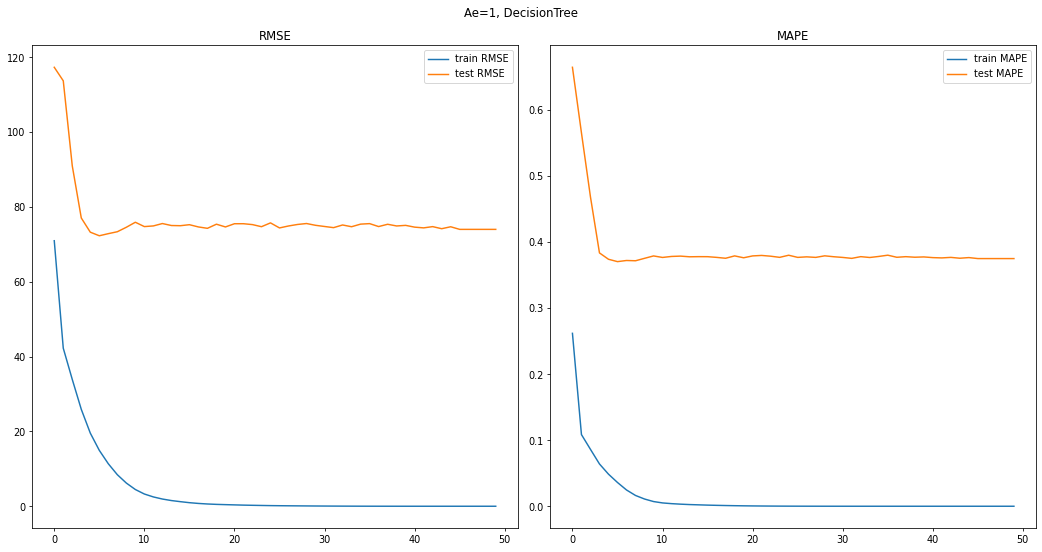

In [23]:
max_depth_curve(1,50,'Ae=1',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


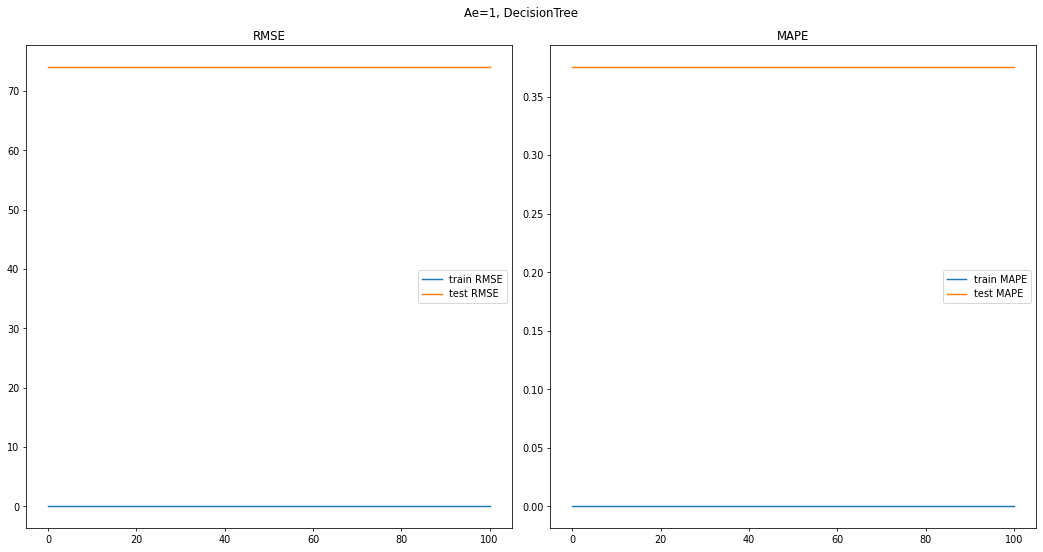

In [24]:
max_depth_curve(100,200,'Ae=1',X_train_scaled,X_test_scaled,y_train,y_test)

In [25]:
dt = DecisionTreeRegressor(max_depth=7,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [26]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
50                    Ap        0.89
52                  feed        0.03
49                    Ae        0.03
29     RMS_Y_CURRENT_std        0.02
7     RMS_SPINDLE_V_mean        0.01
39     RMS_Z_CURRENT_max        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
38     RMS_Z_CURRENT_min        0.00
41    RMS_Z_CURRENT_kurt        0.00
40    RMS_Z_CURRENT_skew        0.00
27    RMS_X_CURRENT_kurt        0.00
42            SOUND_mean        0.00
43             SOUND_std        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [27]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 11.3576
Train MAPE: 0.0247
Test RMSE: 72.8738
Test MAPE: 0.3722


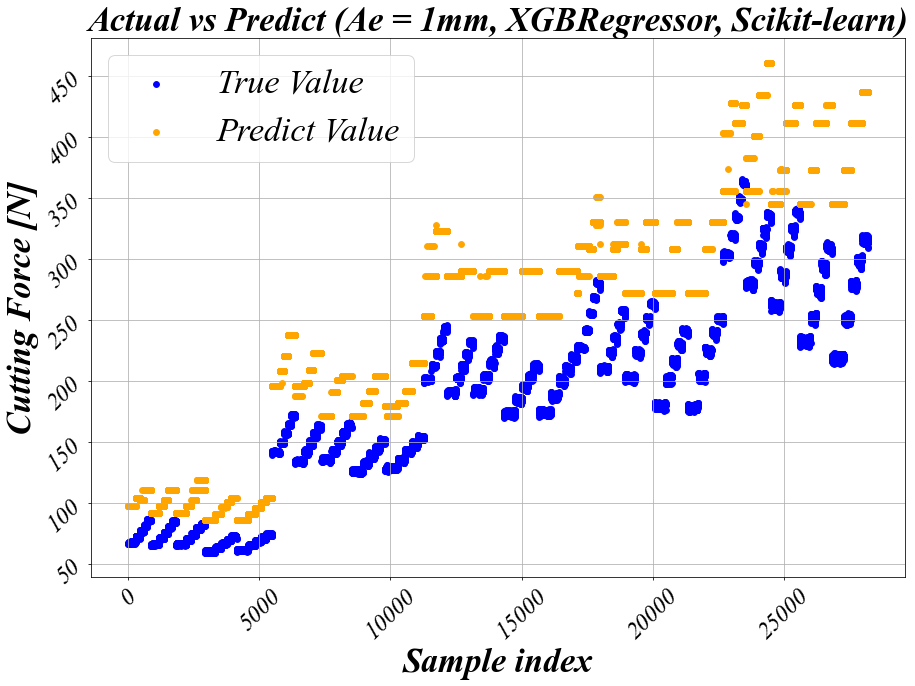

In [28]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 1mm, XGBRegressor, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ae1 cycle.png")

## Ae 2

In [29]:
train = pd.concat([ae_1, ae_3, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [30]:
X_test = ae_2.iloc[: , 1:]
y_test = ae_2['RMS_CF_max']

In [31]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train finish


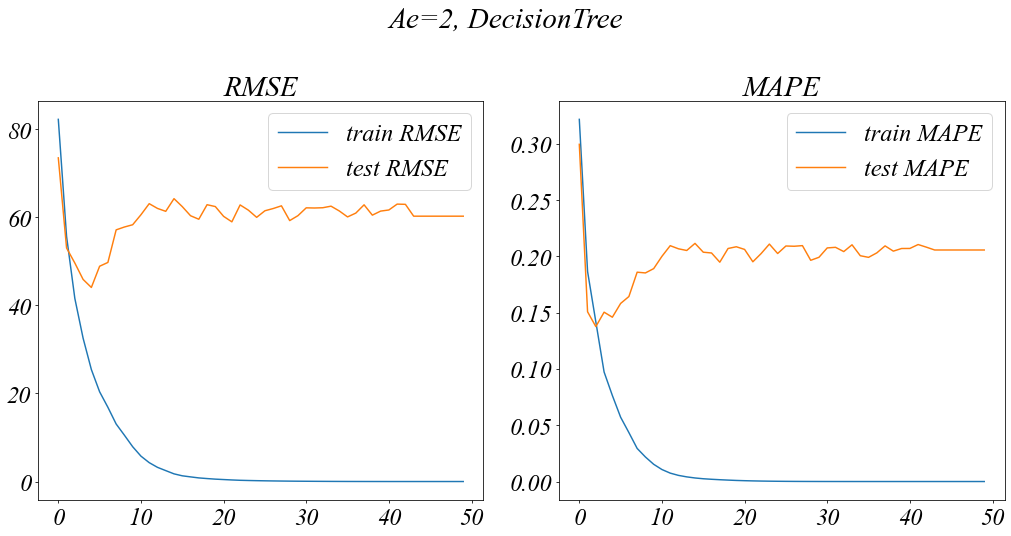

In [32]:
max_depth_curve(1,50,'Ae=2',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


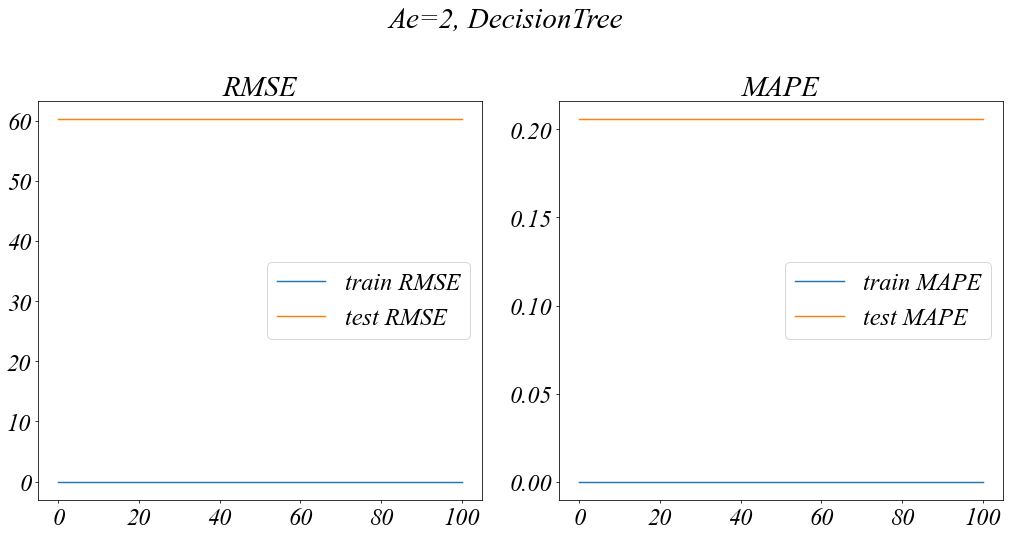

In [33]:
max_depth_curve(100,200,'Ae=2',X_train_scaled,X_test_scaled,y_train,y_test)

In [34]:
dt = DecisionTreeRegressor(max_depth=5,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [35]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.85
35    RMS_Z_CURRENT_mean        0.05
14    RMS_SPINDLE_C_mean        0.03
50                    Ap        0.03
29     RMS_Y_CURRENT_std        0.02
52                  feed        0.01
7     RMS_SPINDLE_V_mean        0.01
4            RMS_ACC_max        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
51                   rpm        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
49                    Ae        0.00
39     RMS_Z_CURRENT_max        0.00
48            SOUND_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
28    RMS_Y_CURRENT_mean        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
4

In [36]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 25.4336
Train MAPE: 0.0765
Test RMSE: 44.0731
Test MAPE: 0.1460


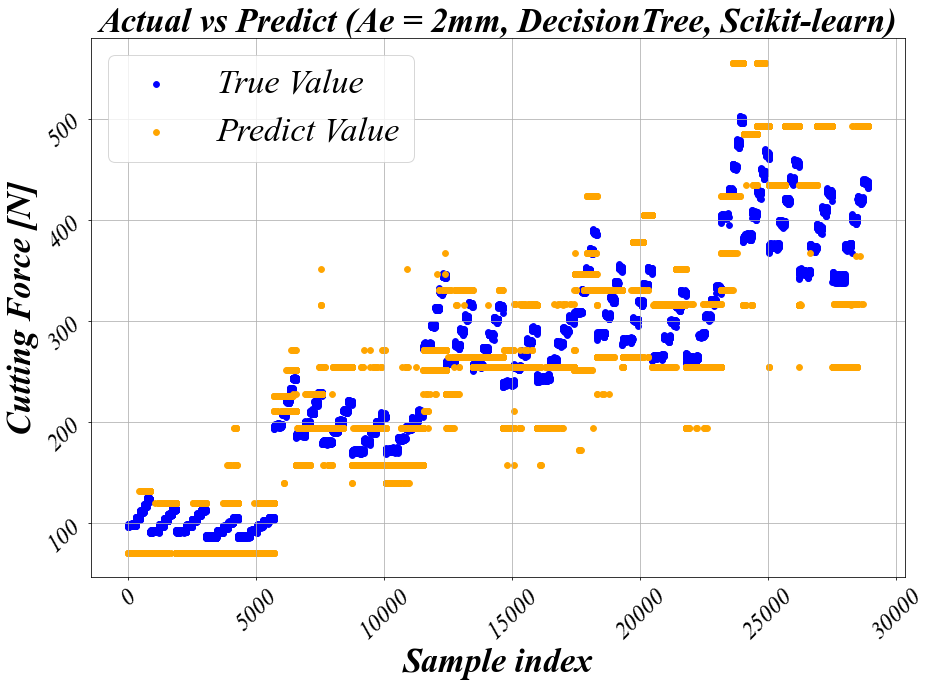

In [37]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 2mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ae2 cycle.png")

## Ae3

In [38]:
train = pd.concat([ae_1, ae_2, ae_4], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [39]:
X_test = ae_3.iloc[: , 1:]
y_test = ae_3['RMS_CF_max']

In [40]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


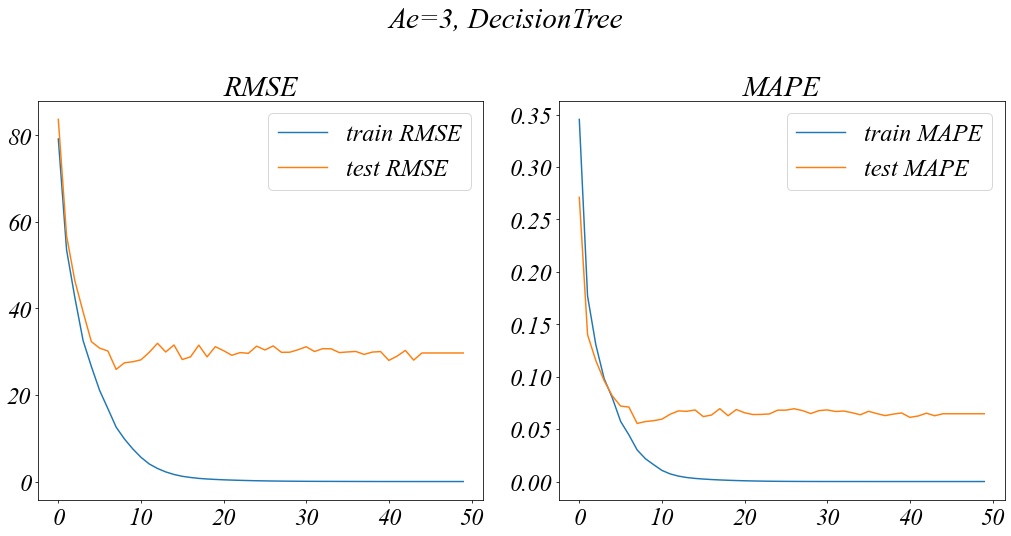

In [41]:
max_depth_curve(1,50,'Ae=3',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


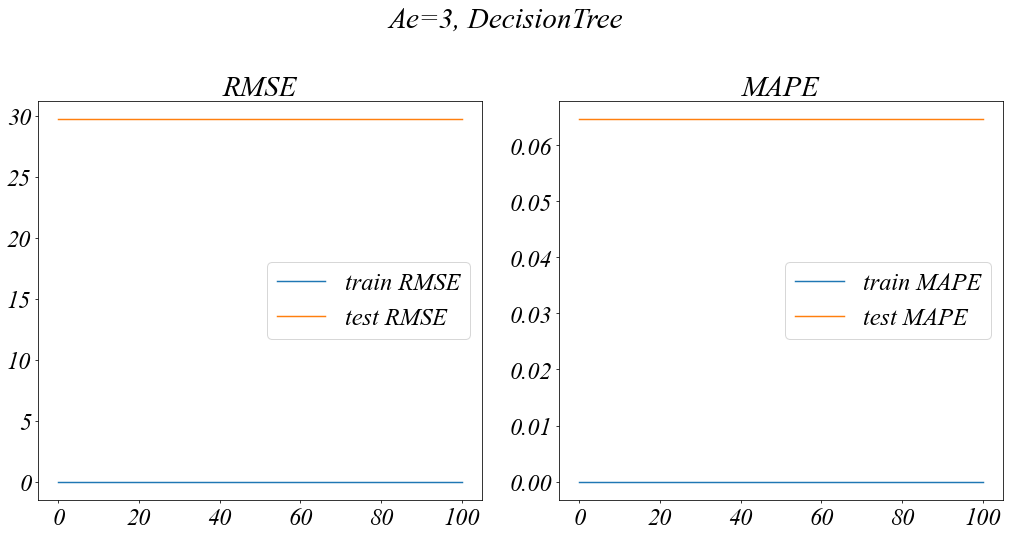

In [42]:
max_depth_curve(100,200,'Ae=3',X_train_scaled,X_test_scaled,y_train,y_test)

In [43]:
dt = DecisionTreeRegressor(max_depth=7,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [44]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.72
50                    Ap        0.12
29     RMS_Y_CURRENT_std        0.04
14    RMS_SPINDLE_C_mean        0.04
38     RMS_Z_CURRENT_min        0.03
24     RMS_X_CURRENT_min        0.02
35    RMS_Z_CURRENT_mean        0.01
52                  feed        0.01
49                    Ae        0.01
45             SOUND_min        0.00
36     RMS_Z_CURRENT_std        0.00
30  RMS_Y_CURRENT_median        0.00
51                   rpm        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
37  RMS_Z_CURRENT_median        0.00
44          SOUND_median        0.00
48            SOUND_kurt        0.00
39     RMS_Z_CURRENT_max        0.00
47            SOUND_skew        0.00
28    RMS_Y_CURRENT_mean        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
46             SOUND_max        0.00
4

In [45]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 16.8465
Train MAPE: 0.0445
Test RMSE: 30.1594
Test MAPE: 0.0710


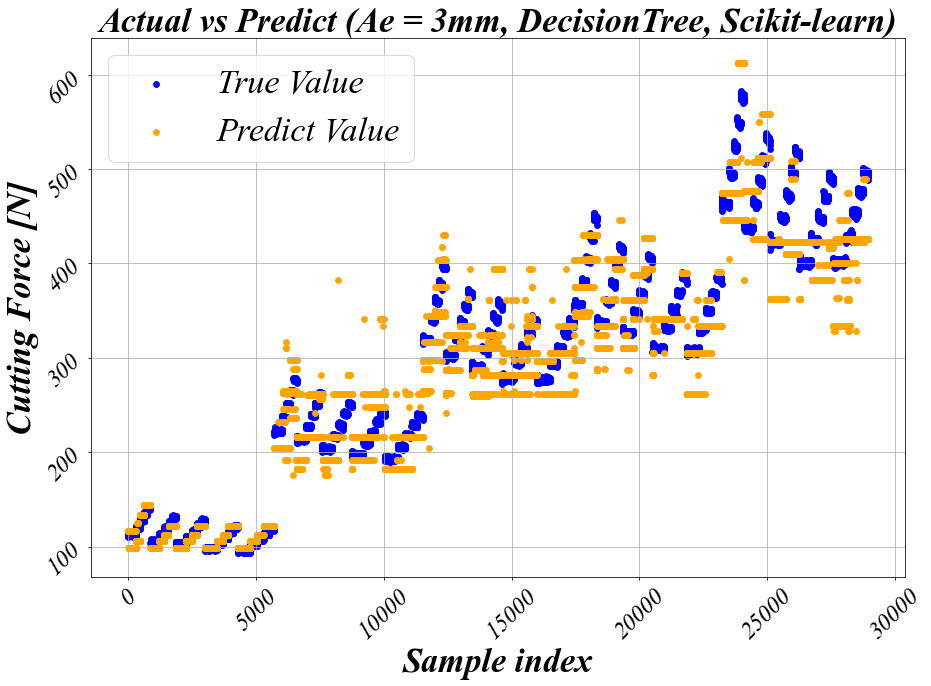

In [46]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 3mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ae3 cycle.png")

## Ae4

In [47]:
train = pd.concat([ae_1, ae_2, ae_3], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [48]:
X_test = ae_4.iloc[: , 1:]
y_test = ae_4['RMS_CF_max']

In [49]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


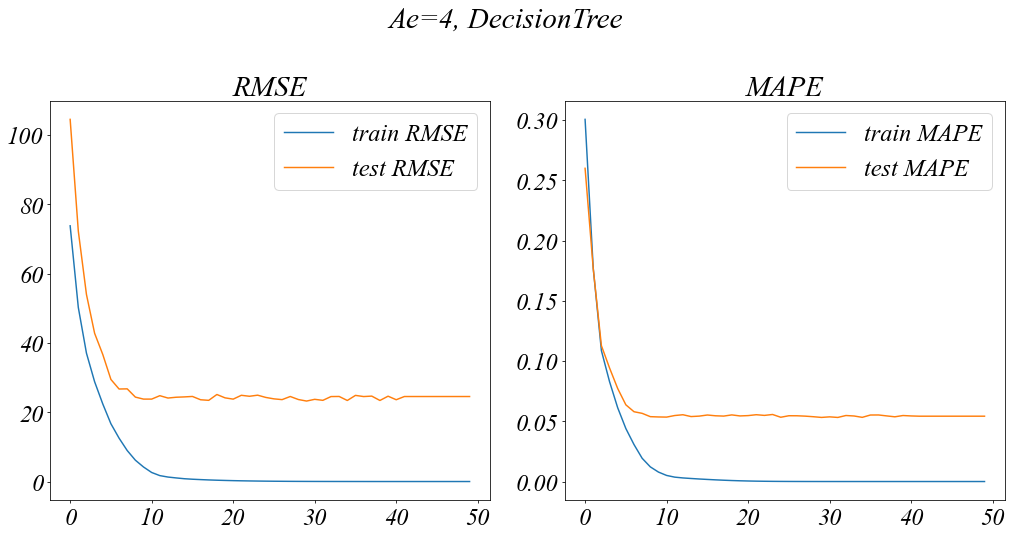

In [50]:
max_depth_curve(1,50,'Ae=4',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


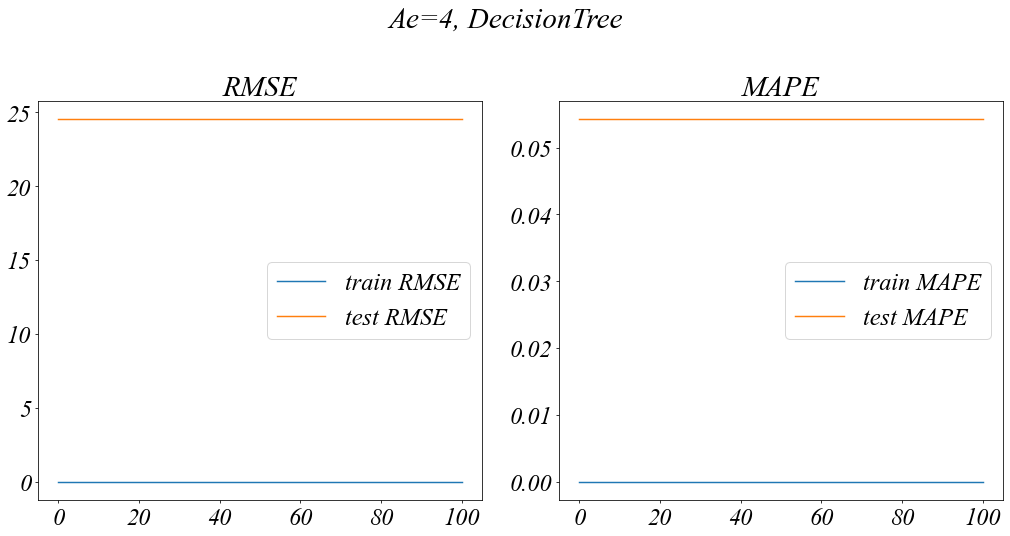

In [51]:
max_depth_curve(100,200,'Ae=4',X_train_scaled,X_test_scaled,y_train,y_test)

In [52]:
dt = DecisionTreeRegressor(max_depth=40,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=40, random_state=42)

In [54]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
50                    Ap        0.68
43             SOUND_std        0.16
49                    Ae        0.09
52                  feed        0.03
29     RMS_Y_CURRENT_std        0.01
36     RMS_Z_CURRENT_std        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
0

In [53]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 0.0003
Train MAPE: 0.0000
Test RMSE: 24.6297
Test MAPE: 0.0548


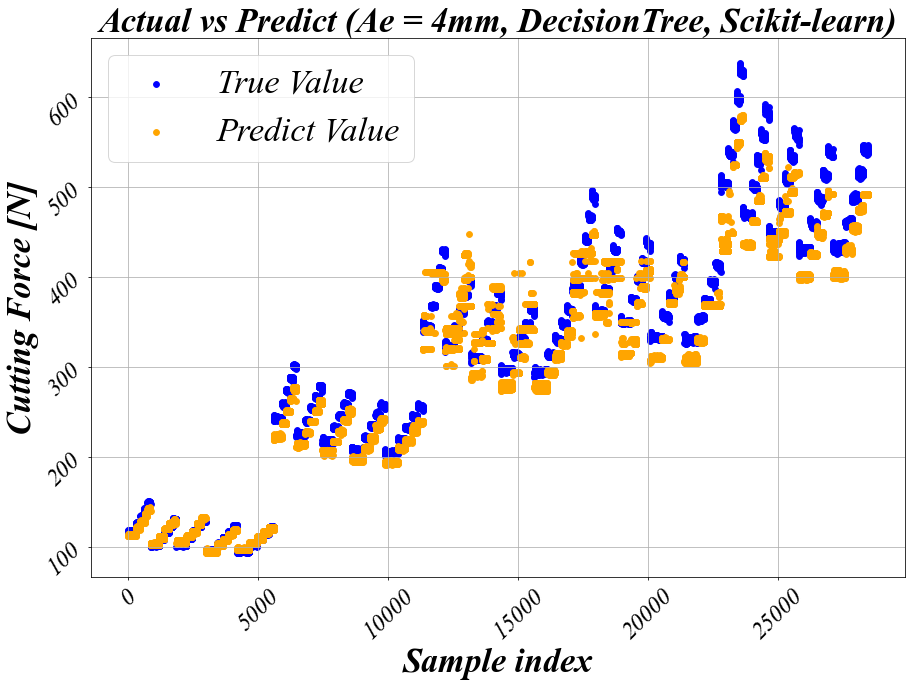

In [56]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ae = 4mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ae4 cycle.png")

# Ap

In [57]:
ap_100 = groups_ap.get_group(1)
ap_100 = ap_100.reset_index(drop=True)
ap_100 = ap_100.drop(['Milling_Type'], axis=1)

ap_225 = groups_ap.get_group(2.25)
ap_225 = ap_225.reset_index(drop=True)
ap_225 = ap_225.drop(['Milling_Type'], axis=1)

ap_350 = groups_ap.get_group(3.5)
ap_350 = ap_350.reset_index(drop=True)
ap_350 = ap_350.drop(['Milling_Type'], axis=1)

ap_475 = groups_ap.get_group(4.75)
ap_475 = ap_475.reset_index(drop=True)
ap_475 = ap_475.drop(['Milling_Type'], axis=1)

ap_600 = groups_ap.get_group(6)
ap_600 = ap_600.reset_index(drop=True)
ap_600 = ap_600.drop(['Milling_Type'], axis=1)

## Ap 100

In [58]:
train = pd.concat([ap_225, ap_350, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [59]:
X_test = ap_100.iloc[: , 1:]
y_test = ap_100['RMS_CF_max']

In [60]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


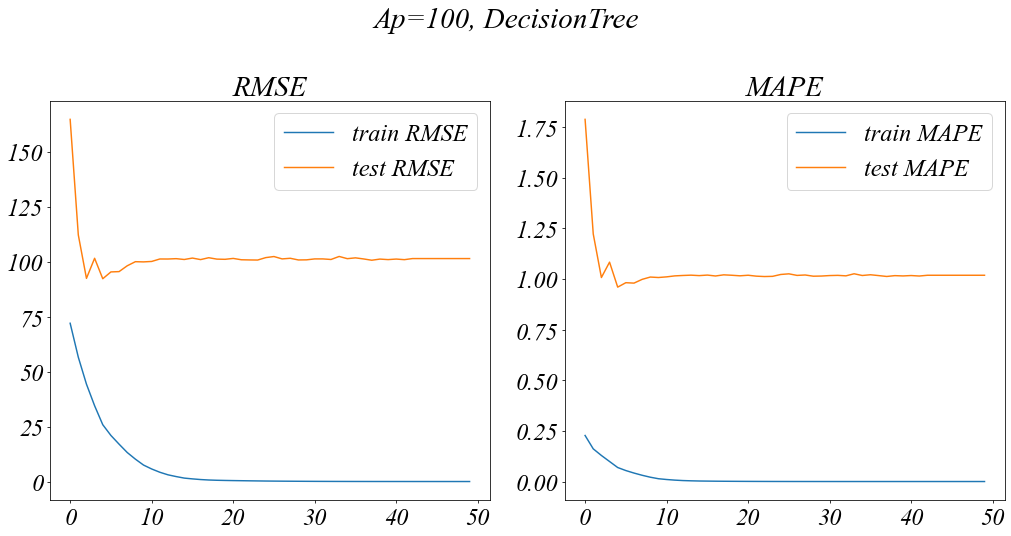

In [61]:
max_depth_curve(1,50,'Ap=100',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


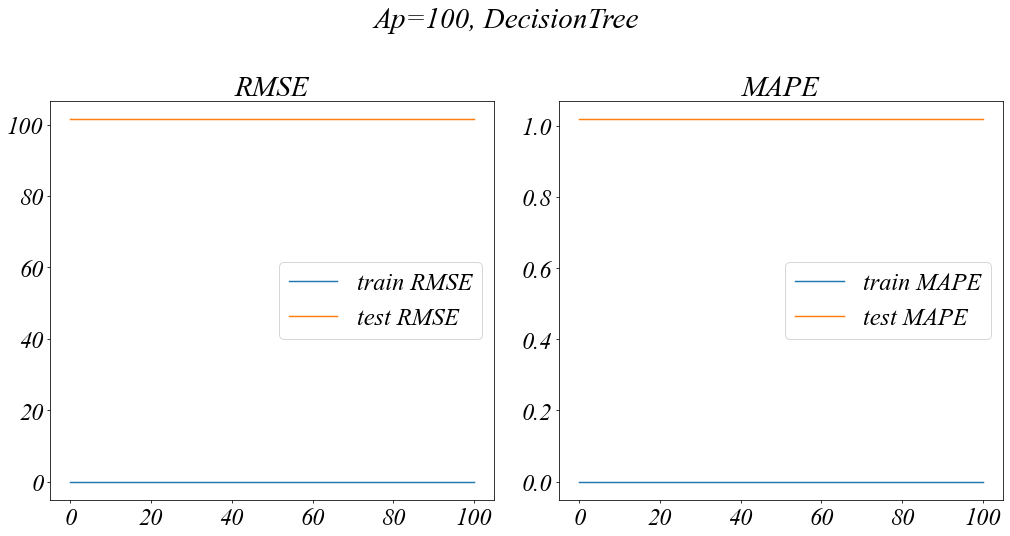

In [62]:
max_depth_curve(100,200,'Ap=100',X_train_scaled,X_test_scaled,y_train,y_test)

In [73]:
dt = DecisionTreeRegressor(max_depth=5,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [74]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.69
50                    Ap        0.08
35    RMS_Z_CURRENT_mean        0.06
49                    Ae        0.06
29     RMS_Y_CURRENT_std        0.05
14    RMS_SPINDLE_C_mean        0.03
52                  feed        0.02
7     RMS_SPINDLE_V_mean        0.01
46             SOUND_max        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
51                   rpm        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
38     RMS_Z_CURRENT_min        0.00
39     RMS_Z_CURRENT_max        0.00
40    RMS_Z_CURRENT_skew        0.00
48            SOUND_kurt        0.00
28    RMS_Y_CURRENT_mean        0.00
42            SOUND_mean        0.00
47            SOUND_skew        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
4

In [75]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 25.8739
Train MAPE: 0.0691
Test RMSE: 92.3381
Test MAPE: 0.9601


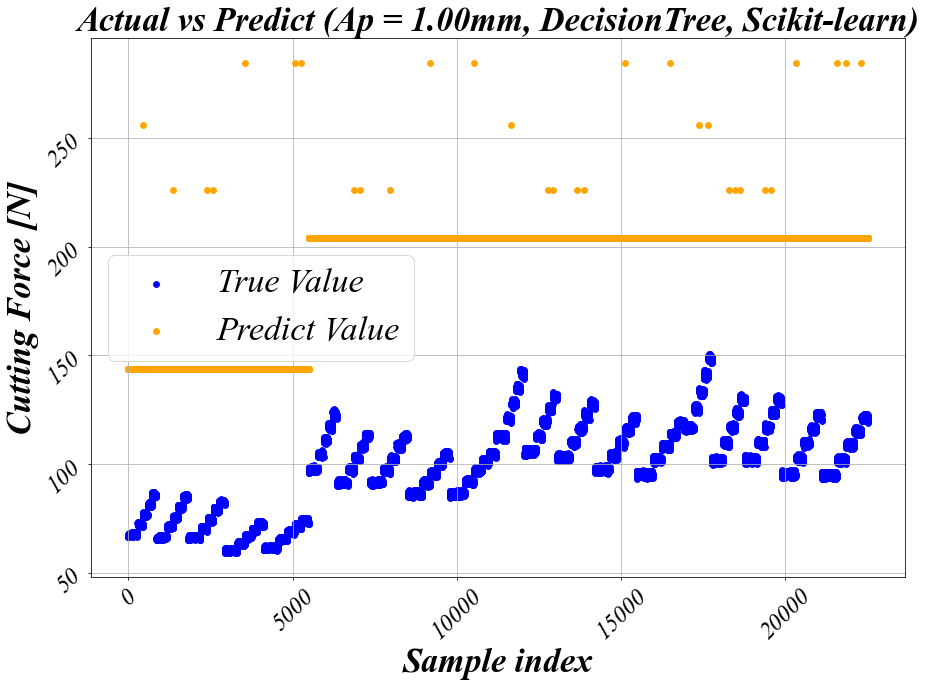

In [76]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 1.00mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ap1 cycle .png")

## Ap 225

In [77]:
train = pd.concat([ap_100, ap_350, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [78]:
X_test = ap_225.iloc[: , 1:]
y_test = ap_225['RMS_CF_max']

In [79]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


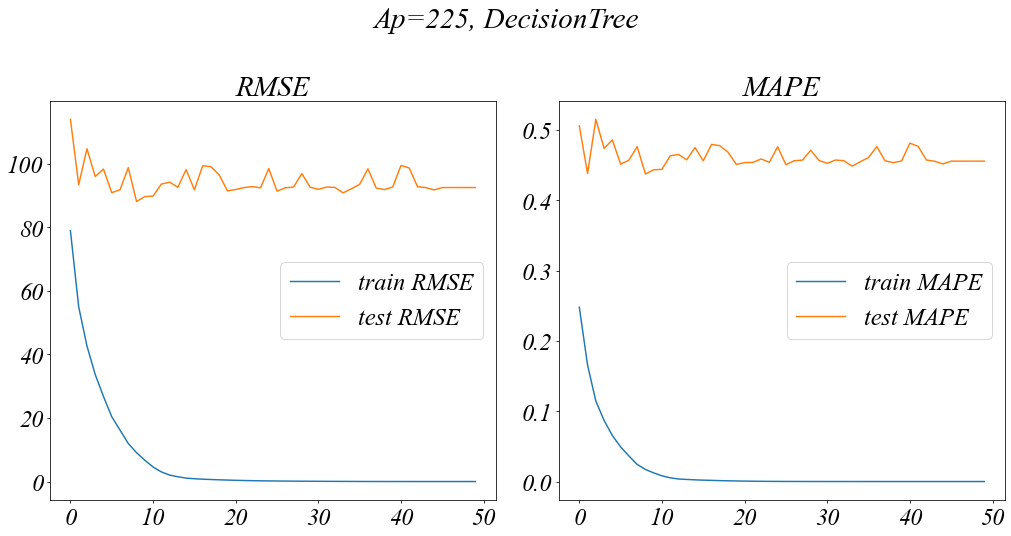

In [80]:
max_depth_curve(1,50,'Ap=225',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


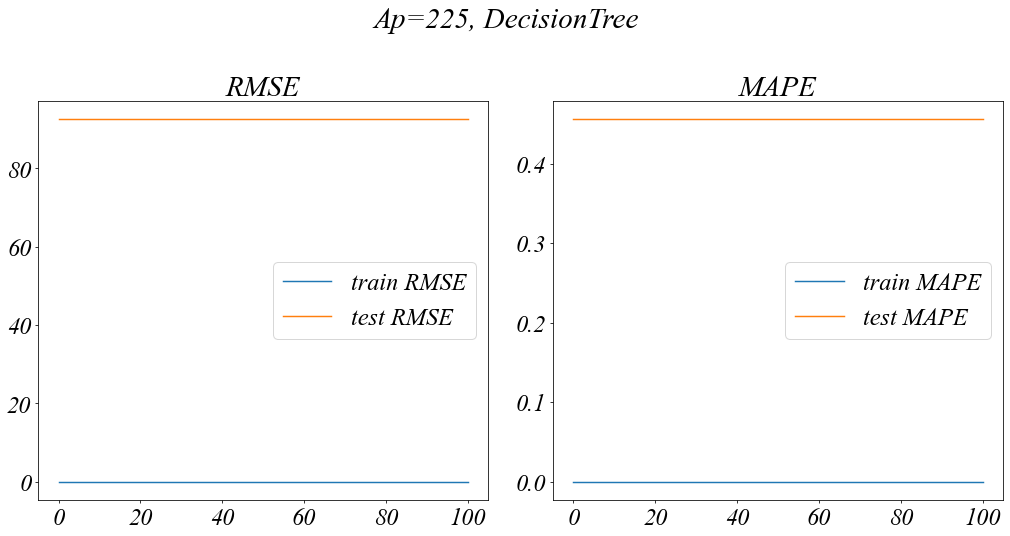

In [81]:
max_depth_curve(100,200,'Ap=225',X_train_scaled,X_test_scaled,y_train,y_test)

In [82]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [83]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
46             SOUND_max        0.64
43             SOUND_std        0.16
50                    Ap        0.08
49                    Ae        0.07
52                  feed        0.02
29     RMS_Y_CURRENT_std        0.02
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
0

In [84]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 6.7150
Train MAPE: 0.0123
Test RMSE: 89.7036
Test MAPE: 0.4433


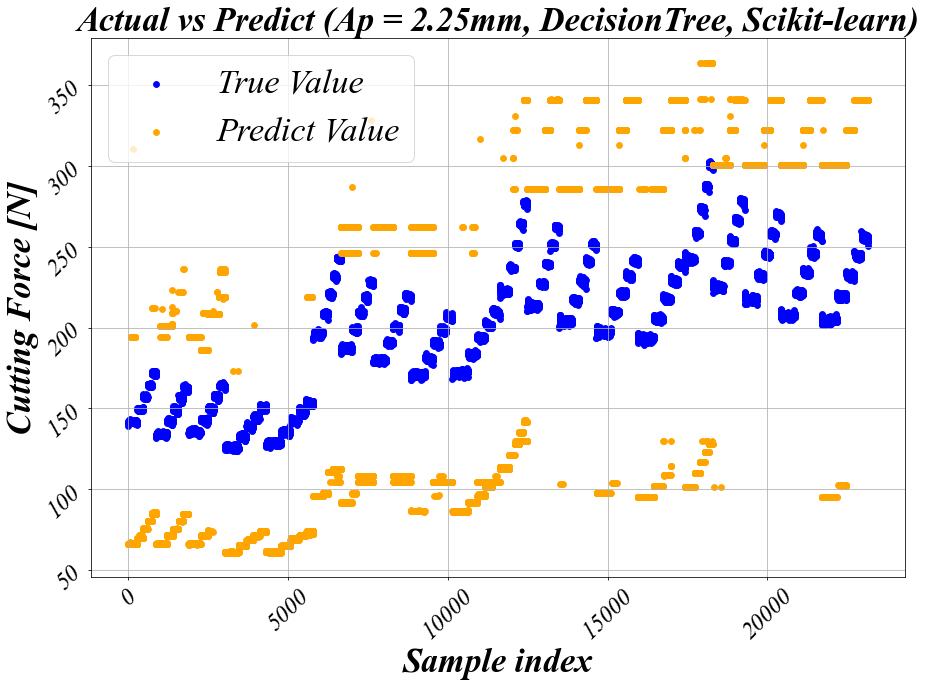

In [85]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 2.25mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ap2.25 cycle.png")

## Ap 350

In [86]:
train = pd.concat([ap_100, ap_225, ap_475, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [87]:
X_test = ap_350.iloc[: , 1:]
y_test = ap_350['RMS_CF_max']

In [88]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


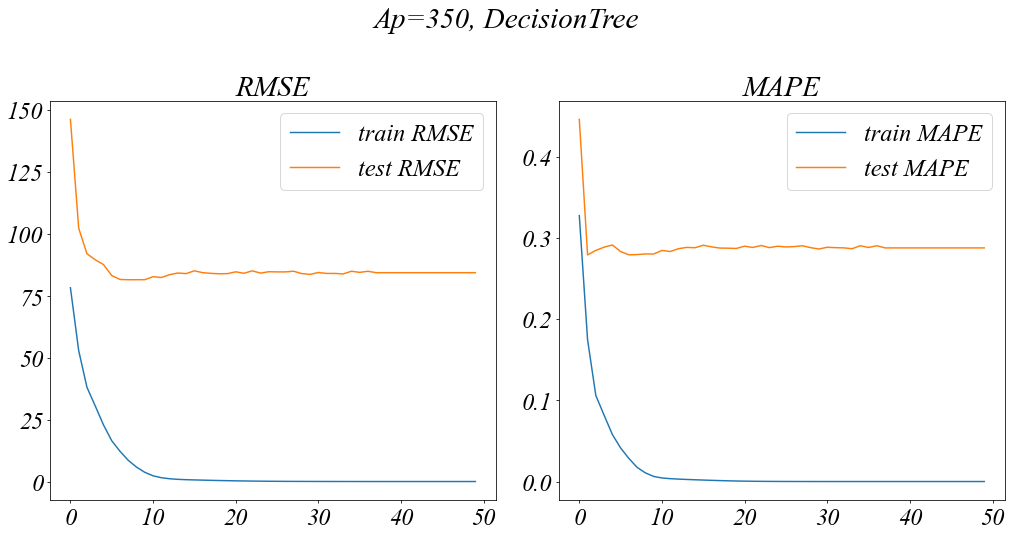

In [89]:
max_depth_curve(1,50,'Ap=350',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


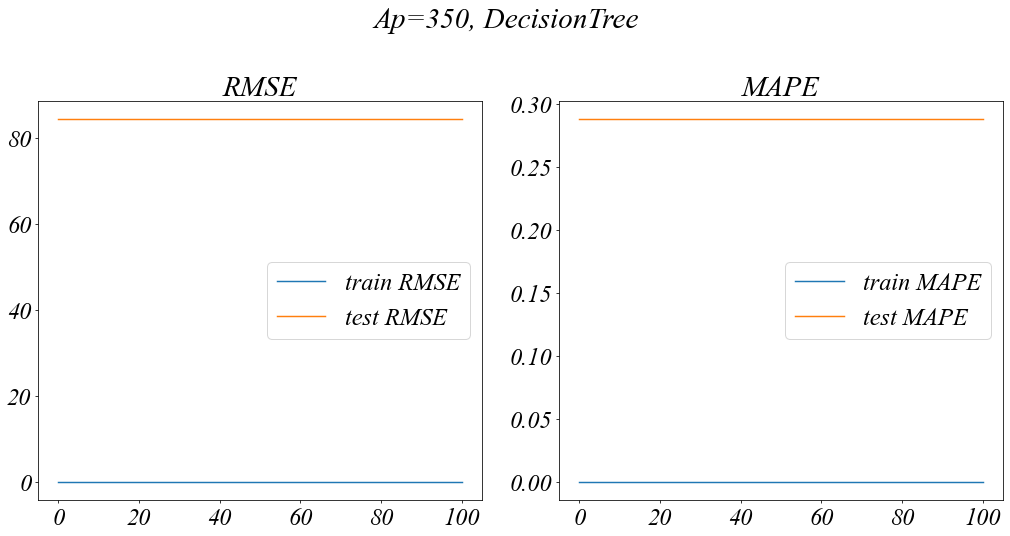

In [90]:
max_depth_curve(100,200,'Ap=350',X_train_scaled,X_test_scaled,y_train,y_test)

In [91]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [92]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
50                    Ap        0.76
43             SOUND_std        0.12
49                    Ae        0.07
52                  feed        0.02
29     RMS_Y_CURRENT_std        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
0

In [93]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 3.7110
Train MAPE: 0.0063
Test RMSE: 81.4483
Test MAPE: 0.2801


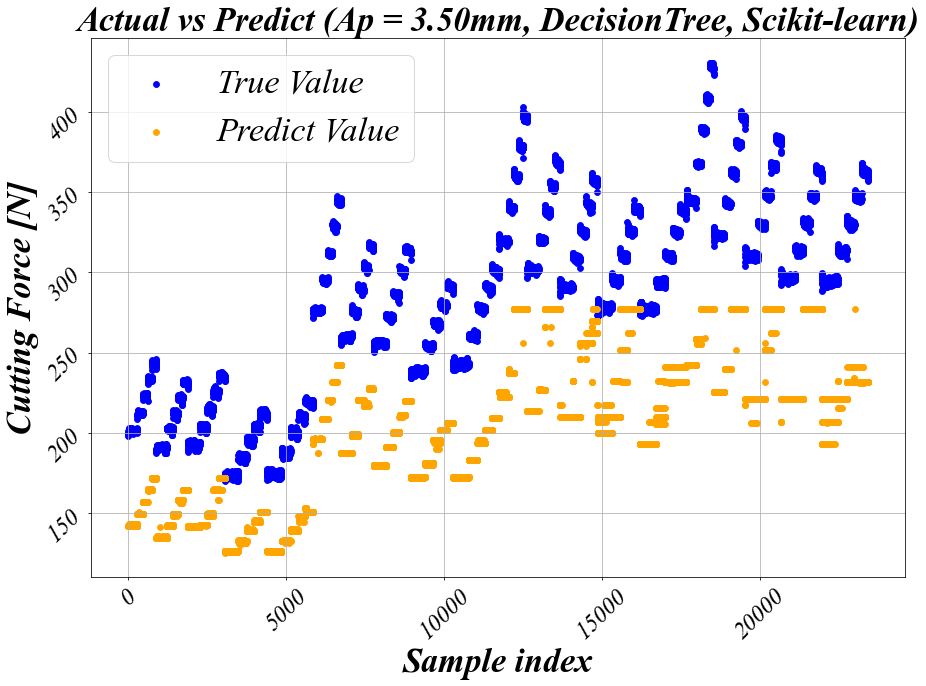

In [94]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 3.50mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ap3.5 cycle.png")

## Ap 475

In [95]:
train = pd.concat([ap_100, ap_225, ap_350, ap_600], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [96]:
X_test = ap_475.iloc[: , 1:]
y_test = ap_475['RMS_CF_max']

In [97]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


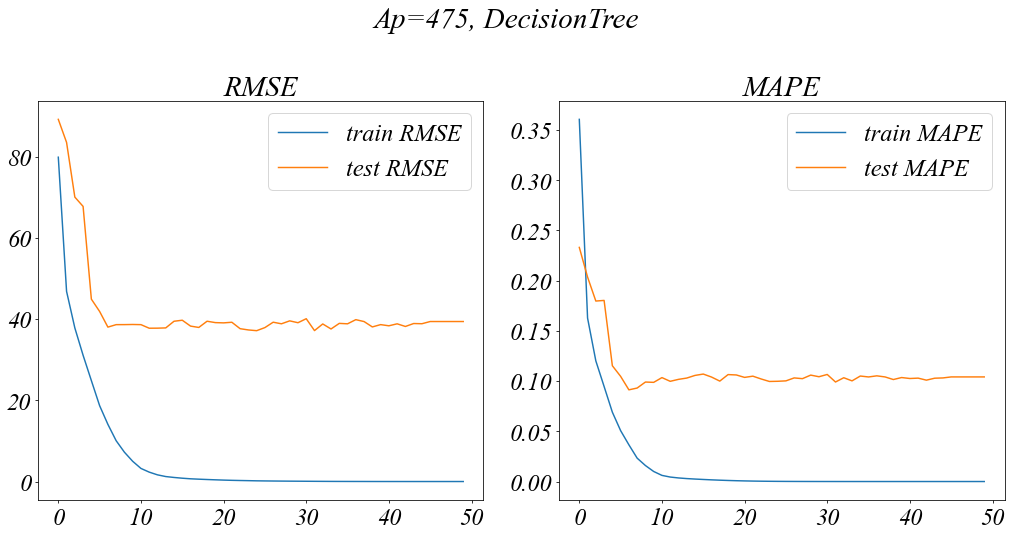

In [98]:
max_depth_curve(1,50,'Ap=475',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


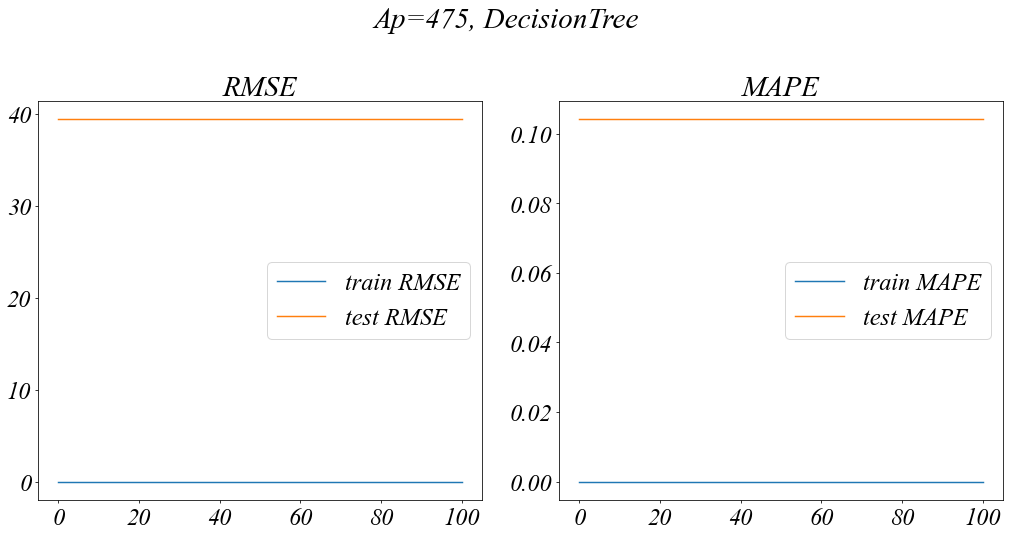

In [99]:
max_depth_curve(100,200,'Ap=475',X_train_scaled,X_test_scaled,y_train,y_test)

In [100]:
dt = DecisionTreeRegressor(max_depth=7,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [101]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
45             SOUND_min        0.62
50                    Ap        0.14
43             SOUND_std        0.14
29     RMS_Y_CURRENT_std        0.05
49                    Ae        0.03
52                  feed        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
0

In [102]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 14.0804
Train MAPE: 0.0366
Test RMSE: 38.0361
Test MAPE: 0.0913


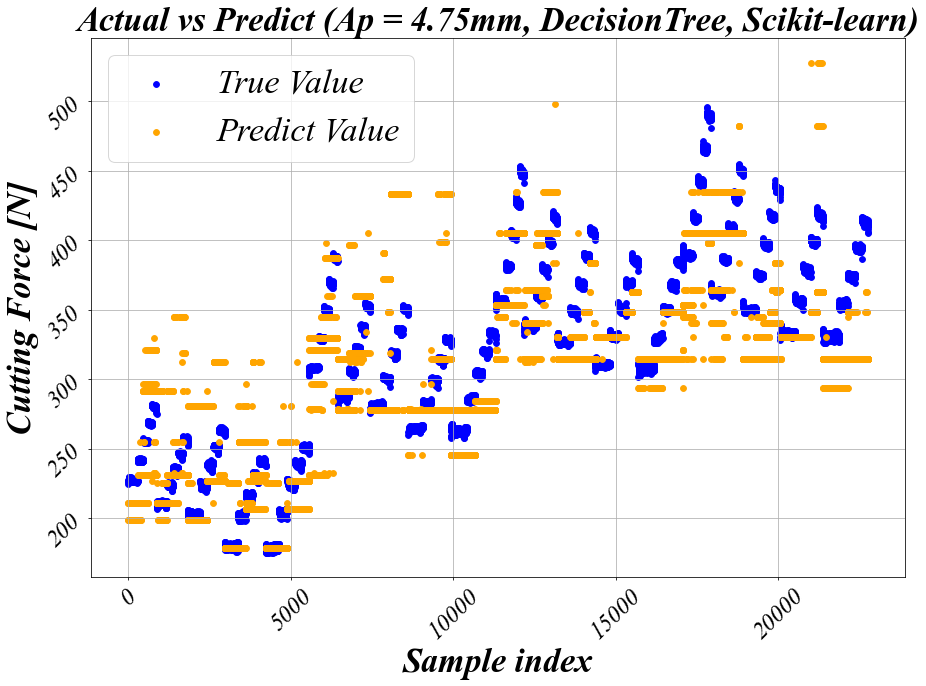

In [103]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 4.75mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ap4.75 cycle.png")

## Ap 600

In [104]:
train = pd.concat([ap_100, ap_225, ap_350, ap_475], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [105]:
X_test = ap_600.iloc[: , 1:]
y_test = ap_600['RMS_CF_max']

In [106]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


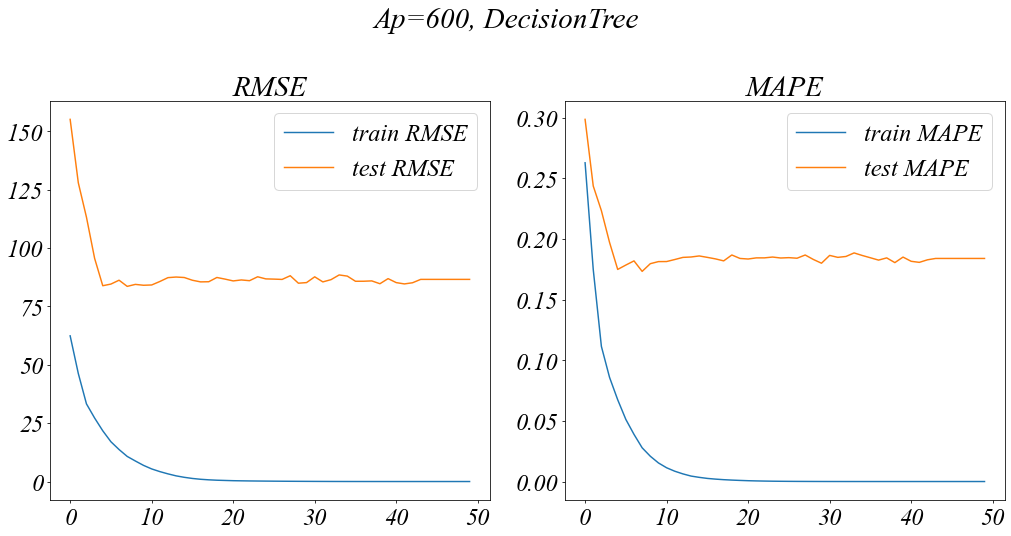

In [107]:
max_depth_curve(1,50,'Ap=600',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


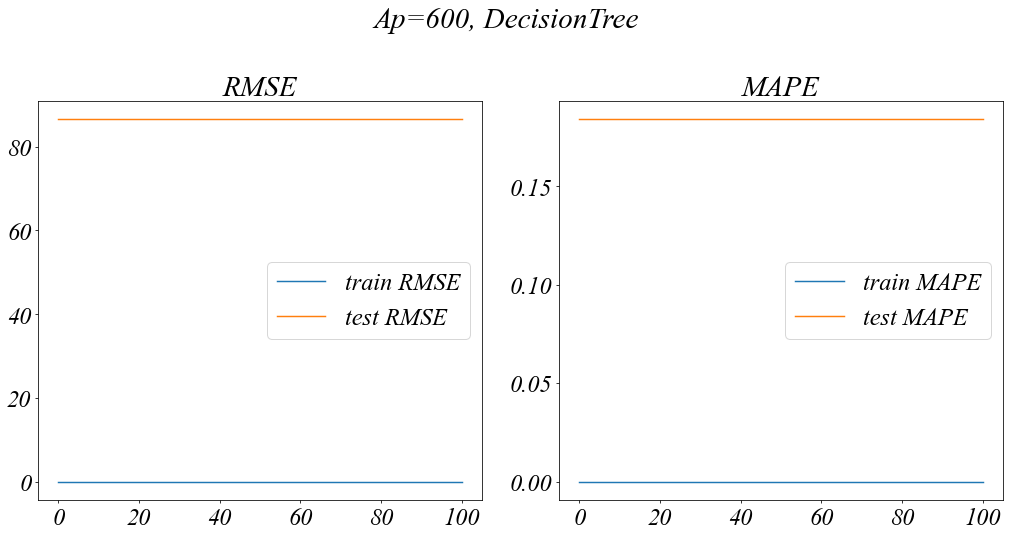

In [108]:
max_depth_curve(100,200,'Ap=600',X_train_scaled,X_test_scaled,y_train,y_test)

In [109]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [110]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.67
29     RMS_Y_CURRENT_std        0.13
50                    Ap        0.07
49                    Ae        0.04
35    RMS_Z_CURRENT_mean        0.02
14    RMS_SPINDLE_C_mean        0.02
36     RMS_Z_CURRENT_std        0.01
52                  feed        0.01
2         RMS_ACC_median        0.01
46             SOUND_max        0.00
37  RMS_Z_CURRENT_median        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
51                   rpm        0.00
38     RMS_Z_CURRENT_min        0.00
45             SOUND_min        0.00
39     RMS_Z_CURRENT_max        0.00
40    RMS_Z_CURRENT_skew        0.00
48            SOUND_kurt        0.00
28    RMS_Y_CURRENT_mean        0.00
42            SOUND_mean        0.00
47            SOUND_skew        0.00
44          SOUND_median        0.00
4

In [111]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 6.9147
Train MAPE: 0.0153
Test RMSE: 84.0480
Test MAPE: 0.1814


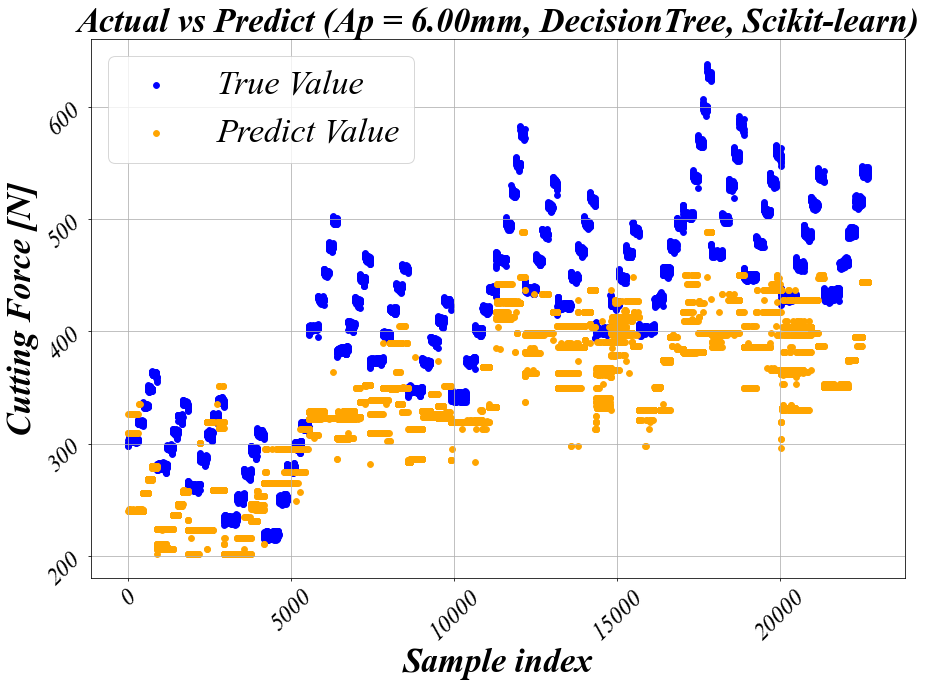

In [112]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (Ap = 6.00mm, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning Ap6.0 cycle.png")

# Feed

In [113]:
feed_300 = groups_feed.get_group(300)
feed_300 = feed_300.reset_index(drop=True)
feed_300 = feed_300.drop(['Milling_Type'], axis=1)

feed_350 = groups_feed.get_group(350)
feed_350 = feed_350.reset_index(drop=True)
feed_350 = feed_350.drop(['Milling_Type'], axis=1)

feed_400 = groups_feed.get_group(400)
feed_400 = feed_400.reset_index(drop=True)
feed_400 = feed_400.drop(['Milling_Type'], axis=1)

feed_450 = groups_feed.get_group(450)
feed_450 = feed_450.reset_index(drop=True)
feed_450 = feed_450.drop(['Milling_Type'], axis=1)

feed_500 = groups_feed.get_group(500)
feed_500 = feed_500.reset_index(drop=True)
feed_500 = feed_500.drop(['Milling_Type'], axis=1)

## feed 300

In [114]:
train = pd.concat([feed_350, feed_400, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [115]:
X_test = feed_300.iloc[: , 1:]
y_test = feed_300['RMS_CF_max']

In [116]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


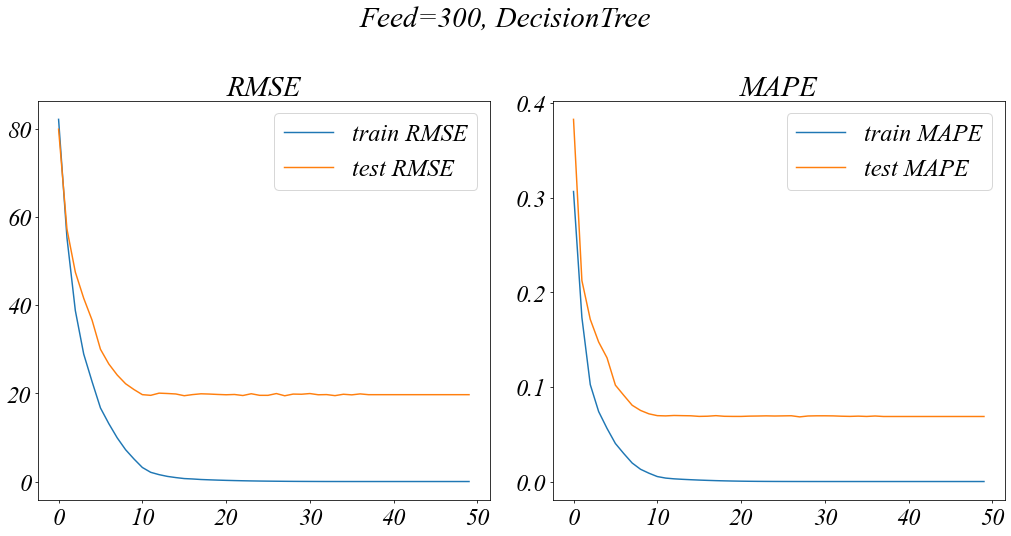

In [117]:
max_depth_curve(1,50,'Feed=300',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


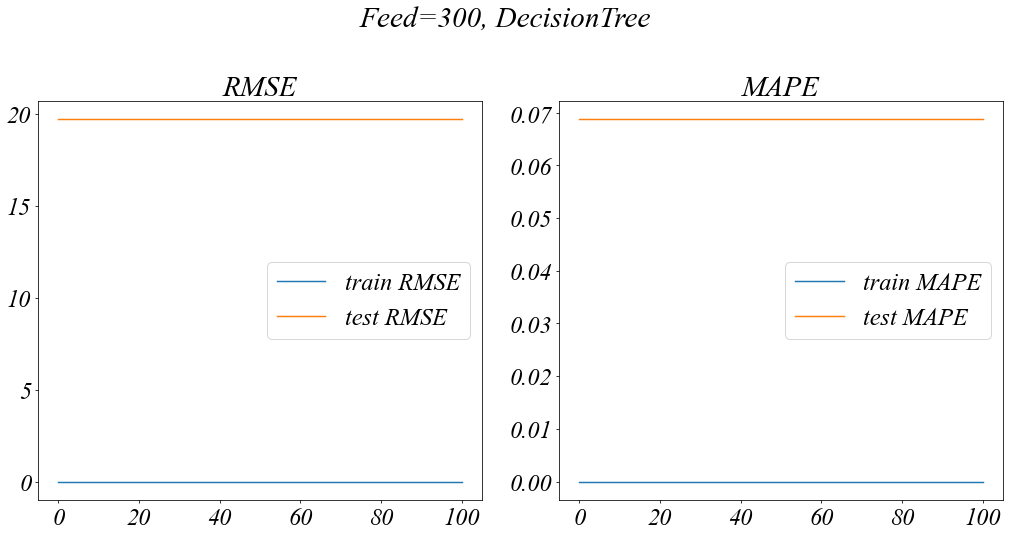

In [118]:
max_depth_curve(100,200,'Feed=300',X_train_scaled,X_test_scaled,y_train,y_test)

In [119]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [120]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
50                    Ap        0.69
43             SOUND_std        0.16
49                    Ae        0.09
29     RMS_Y_CURRENT_std        0.02
52                  feed        0.01
7     RMS_SPINDLE_V_mean        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
41    RMS_Z_CURRENT_kurt        0.00
39     RMS_Z_CURRENT_max        0.00
40    RMS_Z_CURRENT_skew        0.00
27    RMS_X_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [121]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 5.1113
Train MAPE: 0.0088
Test RMSE: 20.8549
Test MAPE: 0.0715


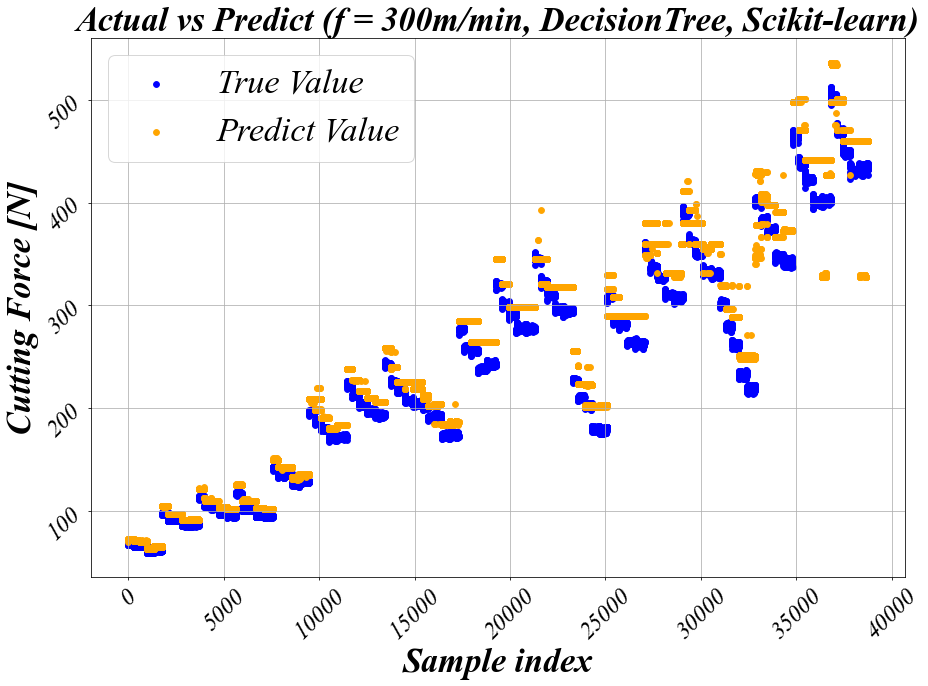

In [122]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 300m/min, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning feed300 cycle.png")

## feed 350

In [123]:
train = pd.concat([feed_300, feed_400, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [124]:
X_test = feed_350.iloc[: , 1:]
y_test = feed_350['RMS_CF_max']

In [125]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


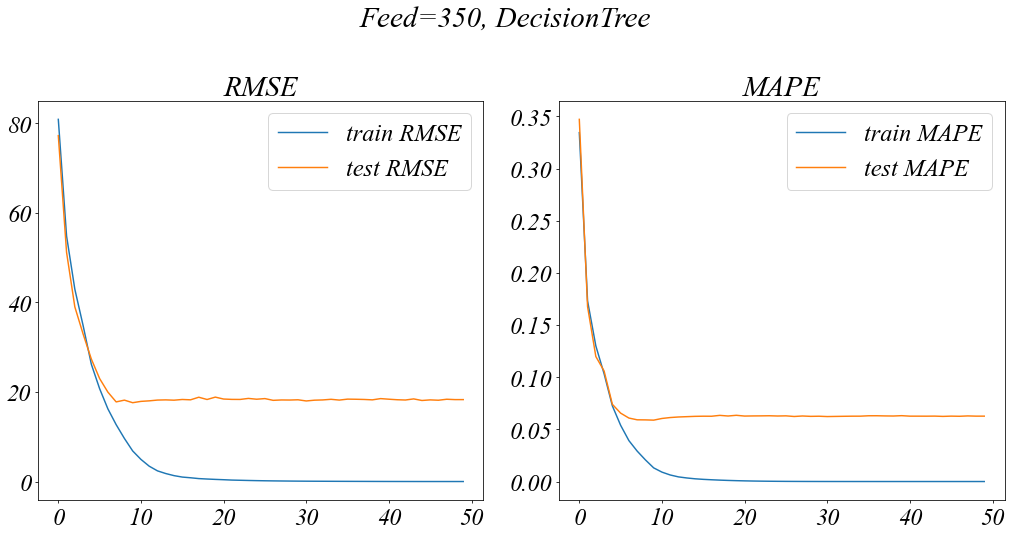

In [126]:
max_depth_curve(1,50,'Feed=350',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


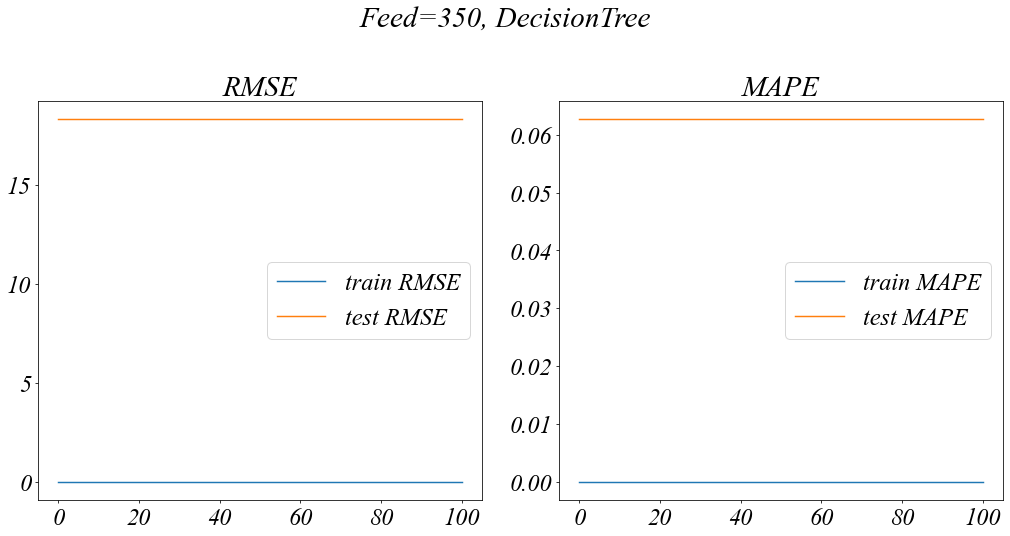

In [127]:
max_depth_curve(100,200,'Feed=350',X_train_scaled,X_test_scaled,y_train,y_test)

In [128]:
dt = DecisionTreeRegressor(max_depth=7,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [129]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.70
50                    Ap        0.15
29     RMS_Y_CURRENT_std        0.06
49                    Ae        0.03
14    RMS_SPINDLE_C_mean        0.03
52                  feed        0.01
38     RMS_Z_CURRENT_min        0.01
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [130]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 16.2218
Train MAPE: 0.0392
Test RMSE: 19.9585
Test MAPE: 0.0609


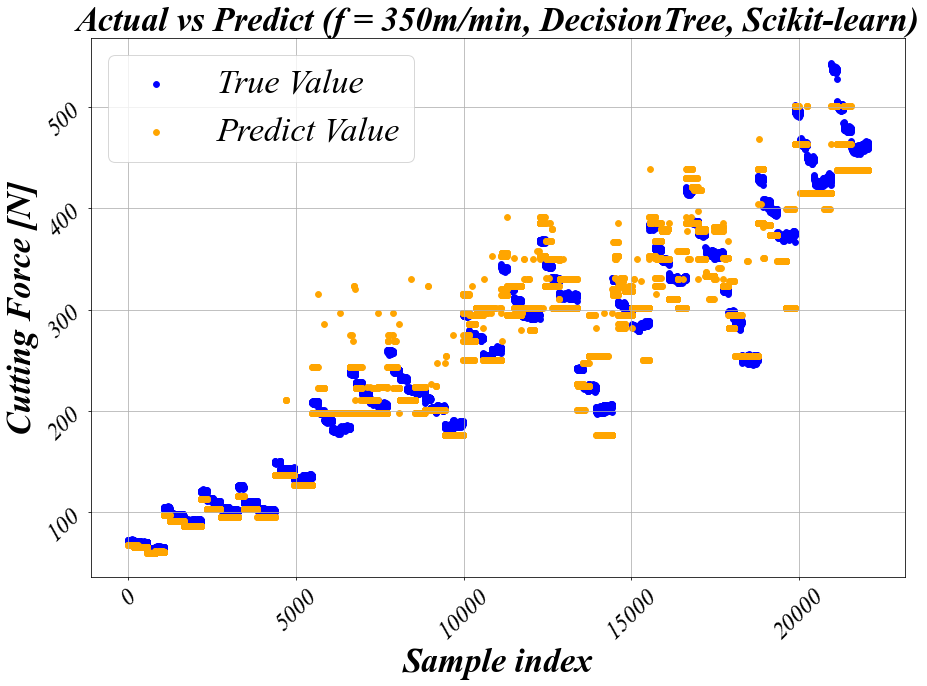

In [131]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 350m/min, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning feed350 cycle.png")

## feed 400

In [132]:
train = pd.concat([feed_300, feed_350, feed_450, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [133]:
X_test = feed_400.iloc[: , 1:]
y_test = feed_400['RMS_CF_max']

In [135]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


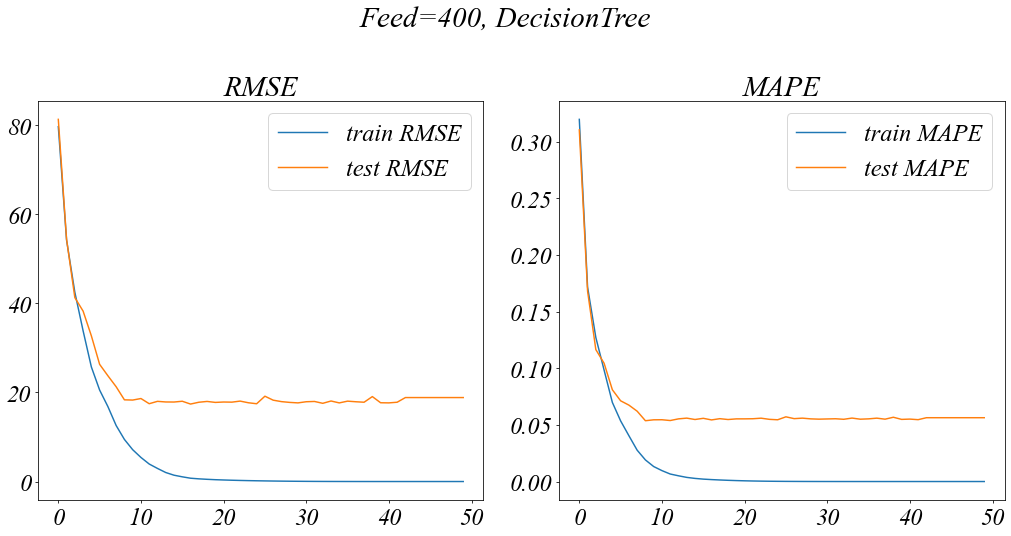

In [136]:
max_depth_curve(1,50,'Feed=400',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


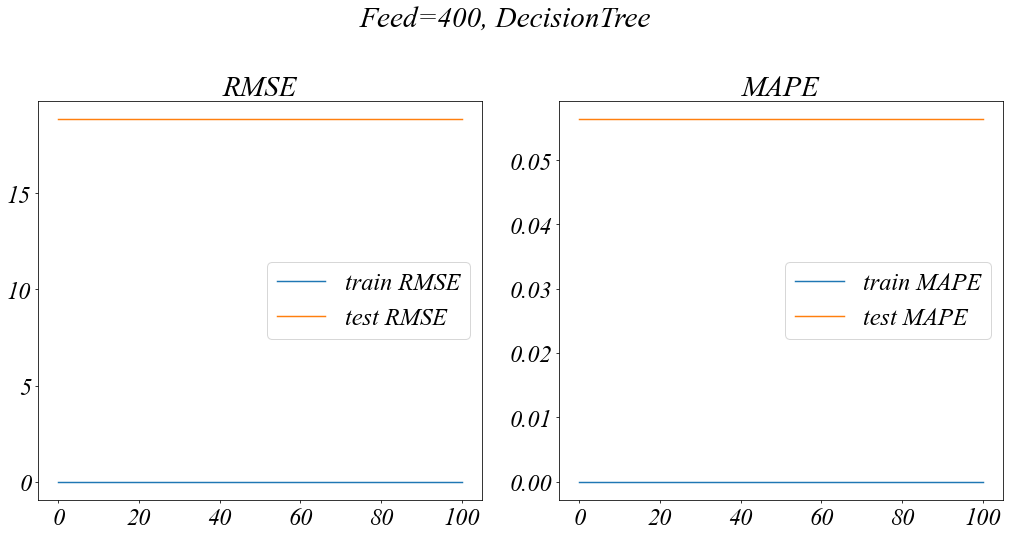

In [137]:
max_depth_curve(100,200,'Feed=400',X_train_scaled,X_test_scaled,y_train,y_test)

In [138]:
dt = DecisionTreeRegressor(max_depth=40,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=40, random_state=42)

In [139]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.73
50                    Ap        0.12
29     RMS_Y_CURRENT_std        0.03
49                    Ae        0.03
35    RMS_Z_CURRENT_mean        0.03
52                  feed        0.02
14    RMS_SPINDLE_C_mean        0.02
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [140]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 0.0003
Train MAPE: 0.0000
Test RMSE: 17.6936
Test MAPE: 0.0549


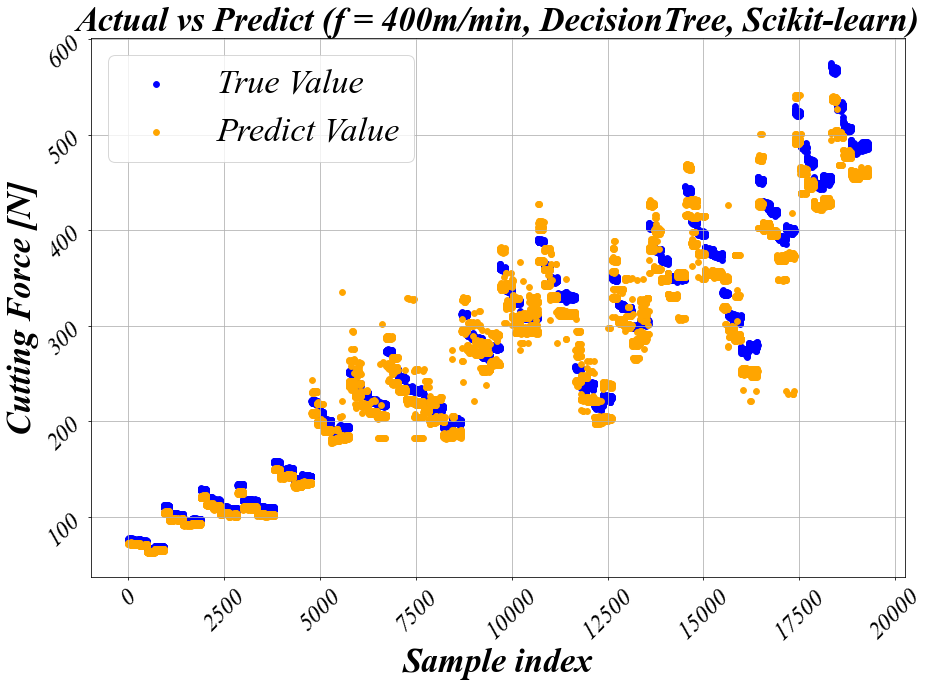

In [141]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 400m/min, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning feed400 cycle.png")

## feed 450

In [142]:
train = pd.concat([feed_300, feed_350, feed_400, feed_500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [143]:
X_test = feed_450.iloc[: , 1:]
y_test = feed_450['RMS_CF_max']

In [144]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


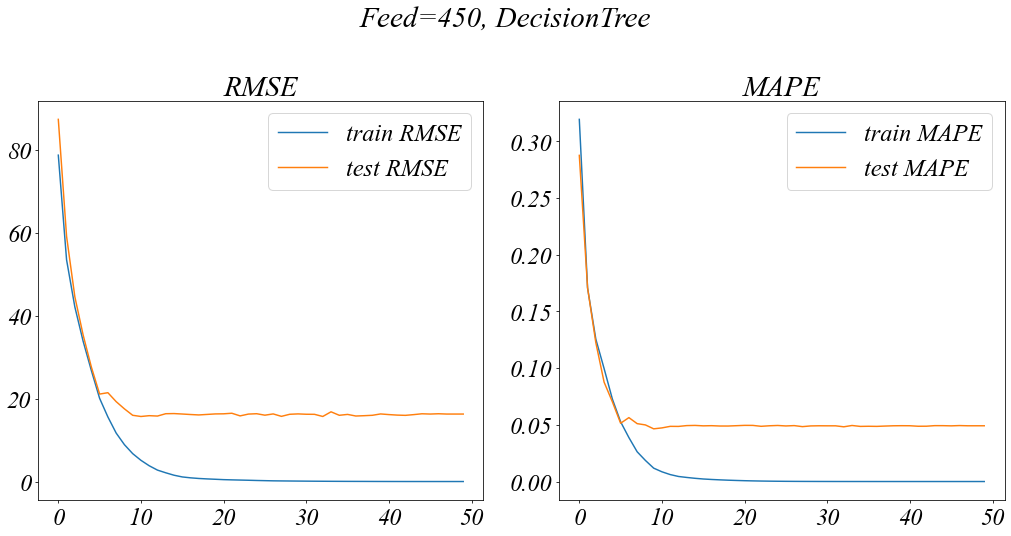

In [145]:
max_depth_curve(1,50,'Feed=450',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


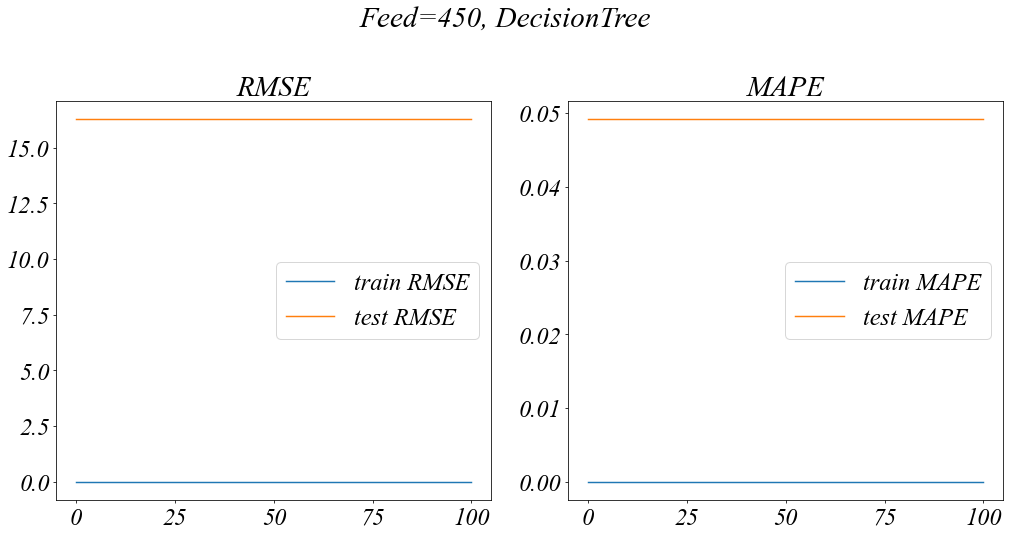

In [146]:
max_depth_curve(100,200,'Feed=450',X_train_scaled,X_test_scaled,y_train,y_test)

In [147]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [148]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.73
50                    Ap        0.12
29     RMS_Y_CURRENT_std        0.03
49                    Ae        0.03
35    RMS_Z_CURRENT_mean        0.03
52                  feed        0.02
14    RMS_SPINDLE_C_mean        0.02
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [149]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 6.7264
Train MAPE: 0.0118
Test RMSE: 15.9691
Test MAPE: 0.0465


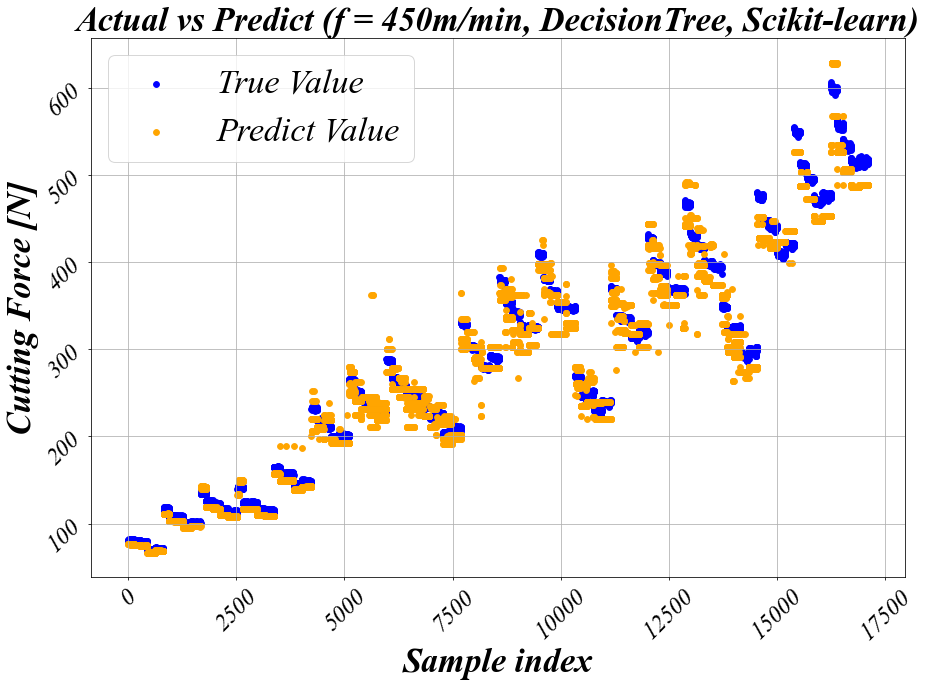

In [150]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 450m/min, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning feed450 cycle.png")

## feed 500

In [151]:
train = pd.concat([feed_300, feed_350, feed_400, feed_450], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [152]:
X_test = feed_500.iloc[: , 1:]
y_test = feed_500['RMS_CF_max']

In [153]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


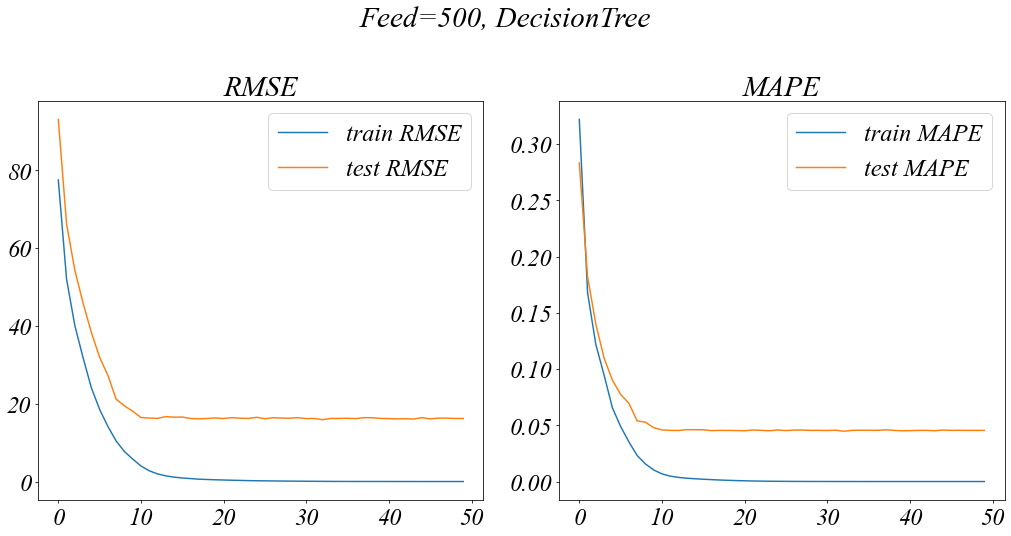

In [154]:
max_depth_curve(1,50,'Feed=500',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


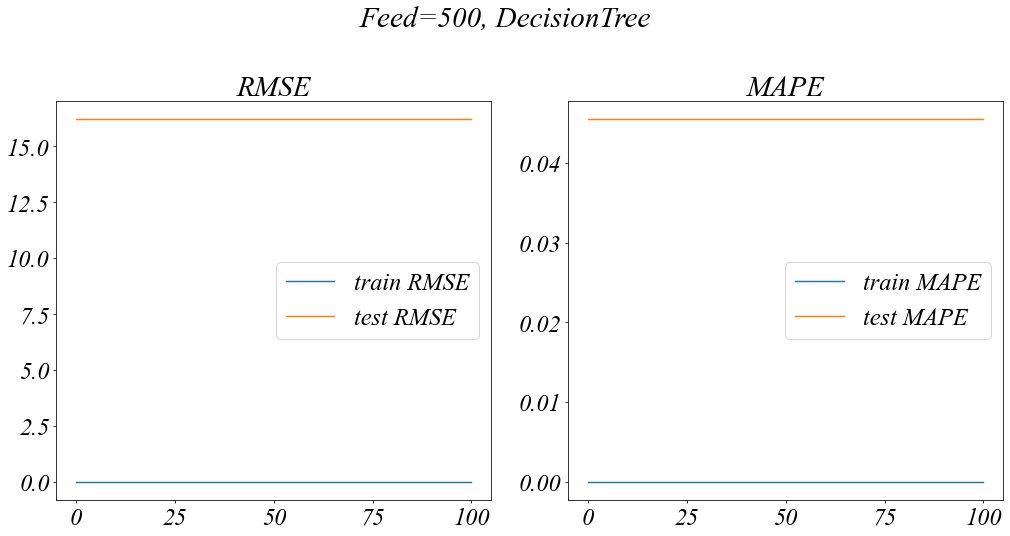

In [155]:
max_depth_curve(100,200,'Feed=500',X_train_scaled,X_test_scaled,y_train,y_test)

In [156]:
dt = DecisionTreeRegressor(max_depth=50,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=50, random_state=42)

In [157]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.71
50                    Ap        0.14
29     RMS_Y_CURRENT_std        0.03
35    RMS_Z_CURRENT_mean        0.03
49                    Ae        0.03
14    RMS_SPINDLE_C_mean        0.02
7     RMS_SPINDLE_V_mean        0.01
52                  feed        0.01
46             SOUND_max        0.00
37  RMS_Z_CURRENT_median        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
51                   rpm        0.00
36     RMS_Z_CURRENT_std        0.00
38     RMS_Z_CURRENT_min        0.00
45             SOUND_min        0.00
39     RMS_Z_CURRENT_max        0.00
40    RMS_Z_CURRENT_skew        0.00
48            SOUND_kurt        0.00
28    RMS_Y_CURRENT_mean        0.00
42            SOUND_mean        0.00
47            SOUND_skew        0.00
44          SOUND_median        0.00
4

In [158]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 0.0000
Train MAPE: 0.0000
Test RMSE: 16.2111
Test MAPE: 0.0455


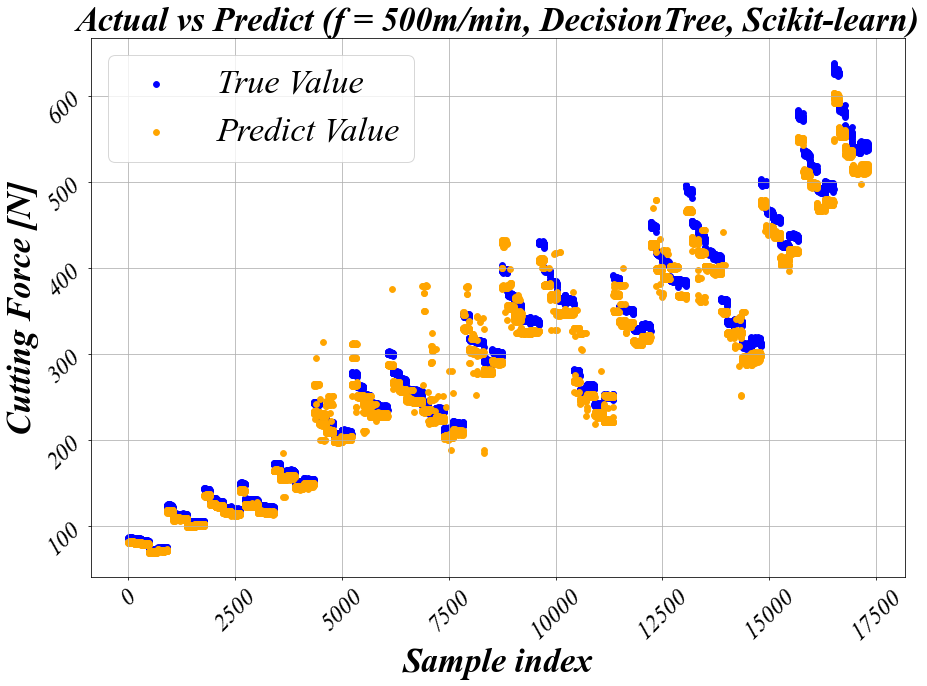

In [159]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (f = 500m/min, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning feed500 cycle.png")

# RPM

In [160]:
rpm_3000 = groups_rpm.get_group(3000)
rpm_3000 = rpm_3000.reset_index(drop=True)
rpm_3000 = rpm_3000.drop(['Milling_Type'], axis=1)

rpm_3500 = groups_rpm.get_group(3500)
rpm_3500 = rpm_3500.reset_index(drop=True)
rpm_3500 = rpm_3500.drop(['Milling_Type'], axis=1)

rpm_4000 = groups_rpm.get_group(4000)
rpm_4000 = rpm_4000.reset_index(drop=True)
rpm_4000 = rpm_4000.drop(['Milling_Type'], axis=1)

rpm_4500 = groups_rpm.get_group(4500)
rpm_4500 = rpm_4500.reset_index(drop=True)
rpm_4500 = rpm_4500.drop(['Milling_Type'], axis=1)

rpm_5000 = groups_rpm.get_group(5000)
rpm_5000 = rpm_5000.reset_index(drop=True)
rpm_5000 = rpm_5000.drop(['Milling_Type'], axis=1)

## rpm 3000

In [161]:
train = pd.concat([rpm_3500, rpm_4000, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [162]:
X_test = rpm_3000.iloc[: , 1:]
y_test = rpm_3000['RMS_CF_max']

In [163]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train finish


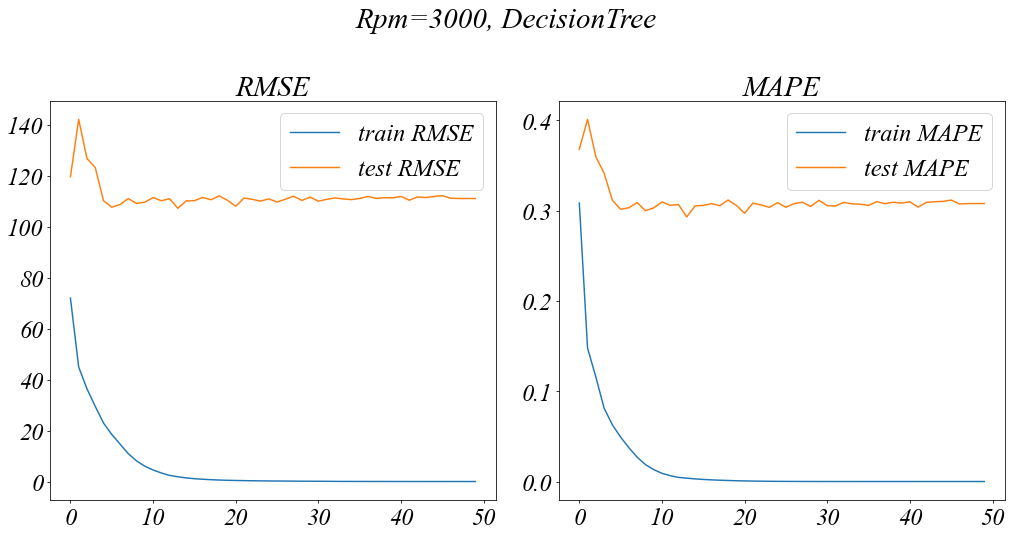

In [164]:
max_depth_curve(1,50,'Rpm=3000',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


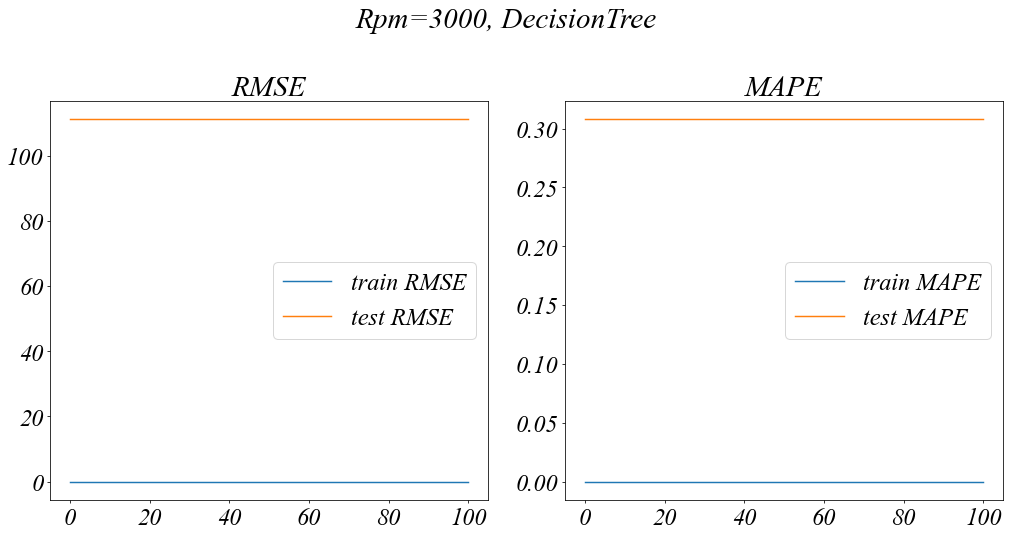

In [165]:
max_depth_curve(100,200,'Rpm=3000',X_train_scaled,X_test_scaled,y_train,y_test)

In [166]:
dt = DecisionTreeRegressor(max_depth=10,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [167]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.77
0           RMS_ACC_mean        0.11
50                    Ap        0.03
49                    Ae        0.03
35    RMS_Z_CURRENT_mean        0.02
52                  feed        0.02
36     RMS_Z_CURRENT_std        0.01
14    RMS_SPINDLE_C_mean        0.01
6           RMS_ACC_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
5           RMS_ACC_skew        0.00
37  RMS_Z_CURRENT_median        0.00
38     RMS_Z_CURRENT_min        0.00
39     RMS_Z_CURRENT_max        0.00
40    RMS_Z_CURRENT_skew        0.00
42            SOUND_mean        0.00
30  RMS_Y_CURRENT_median        0.00
4            RMS_ACC_max        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
3

In [168]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 6.0199
Train MAPE: 0.0132
Test RMSE: 109.7225
Test MAPE: 0.3030


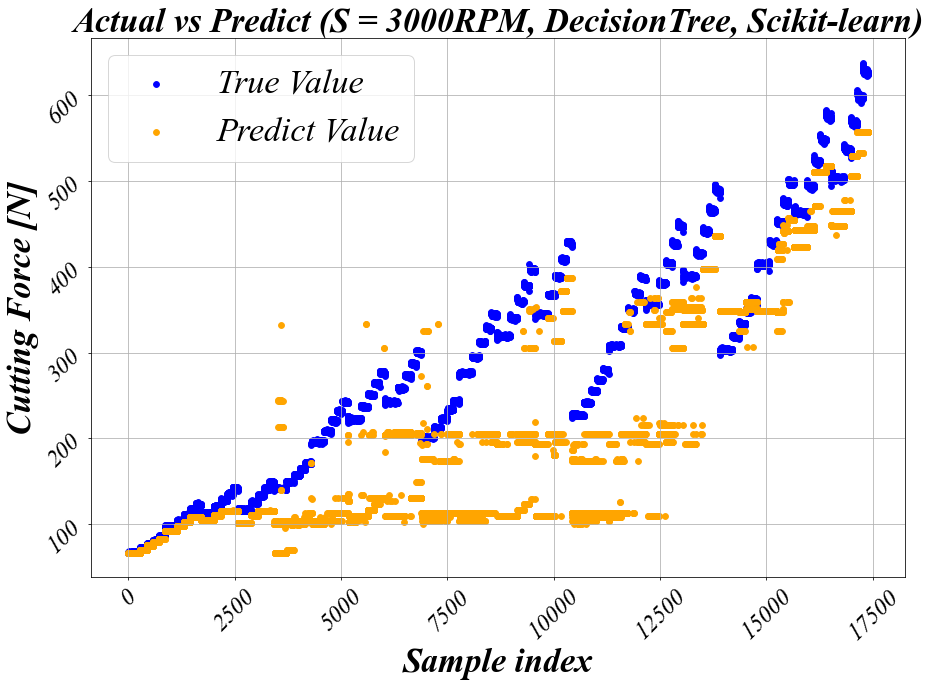

In [169]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 3000RPM, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning rpm3000 cycle.png")

## rpm 3500

In [170]:
train = pd.concat([rpm_3000, rpm_4000, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [171]:
X_test = rpm_3500.iloc[: , 1:]
y_test = rpm_3500['RMS_CF_max']

In [172]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


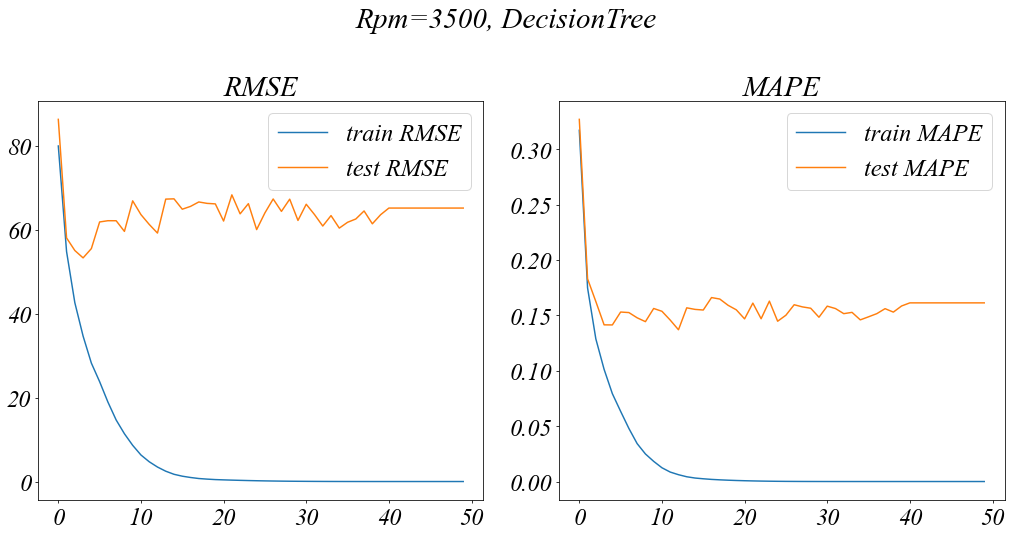

In [173]:
max_depth_curve(1,50,'Rpm=3500',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


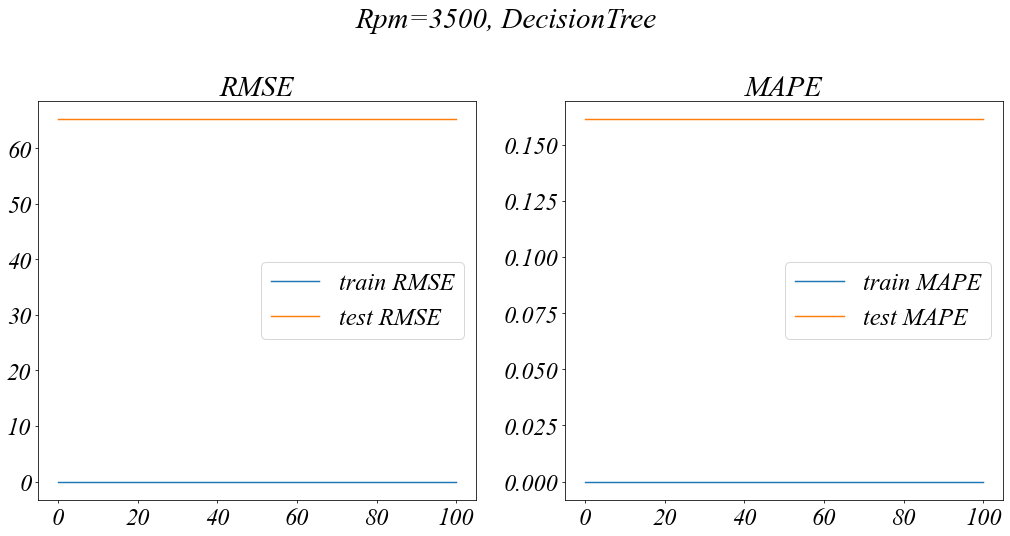

In [174]:
max_depth_curve(100,200,'Rpm=3500',X_train_scaled,X_test_scaled,y_train,y_test)

In [175]:
dt = DecisionTreeRegressor(max_depth=5,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [176]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
45             SOUND_min        0.60
43             SOUND_std        0.18
50                    Ap        0.11
35    RMS_Z_CURRENT_mean        0.04
29     RMS_Y_CURRENT_std        0.03
14    RMS_SPINDLE_C_mean        0.02
49                    Ae        0.01
23  RMS_X_CURRENT_median        0.01
36     RMS_Z_CURRENT_std        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
37  RMS_Z_CURRENT_median        0.00
0           RMS_ACC_mean        0.00
39     RMS_Z_CURRENT_max        0.00
28    RMS_Y_CURRENT_mean        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
4

In [177]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 28.2362
Train MAPE: 0.0794
Test RMSE: 55.5322
Test MAPE: 0.1415


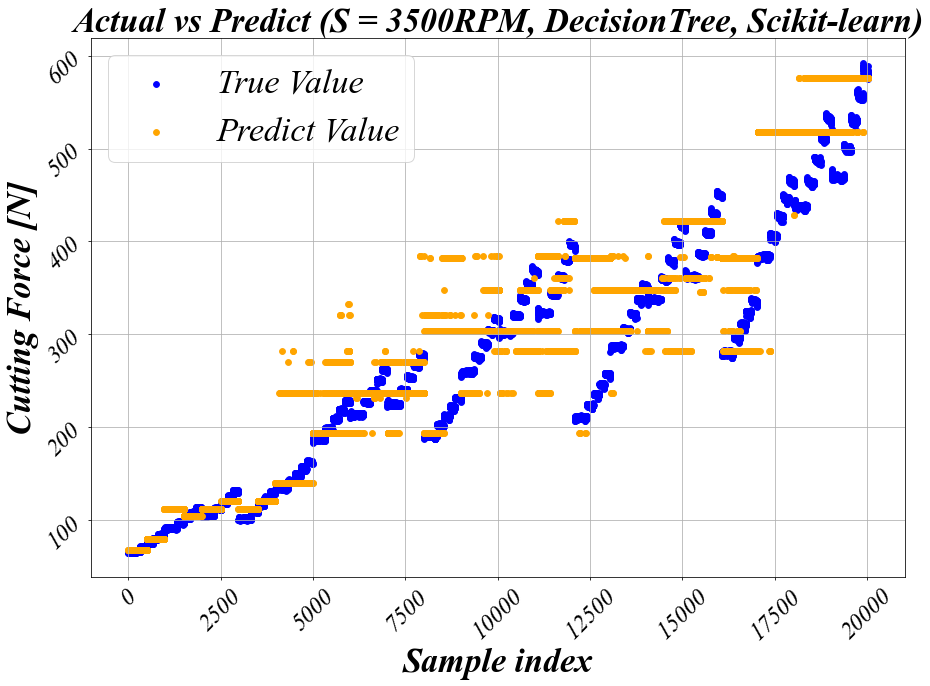

In [178]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 3500RPM, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning rpm3500 cycle.png")

## rpm 4000

In [179]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4500, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [180]:
X_test = rpm_4000.iloc[: , 1:]
y_test = rpm_4000['RMS_CF_max']

In [181]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


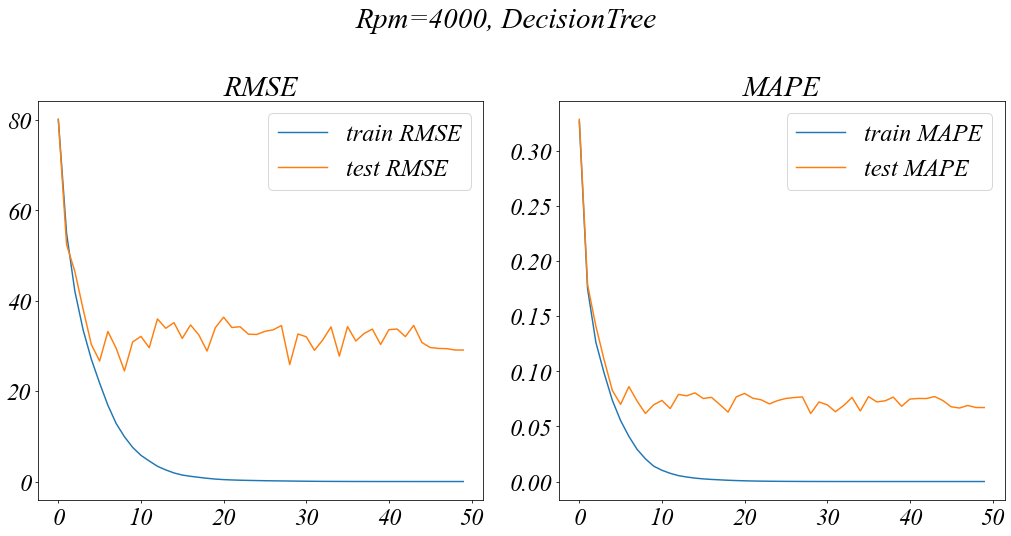

In [182]:
max_depth_curve(1,50,'Rpm=4000',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


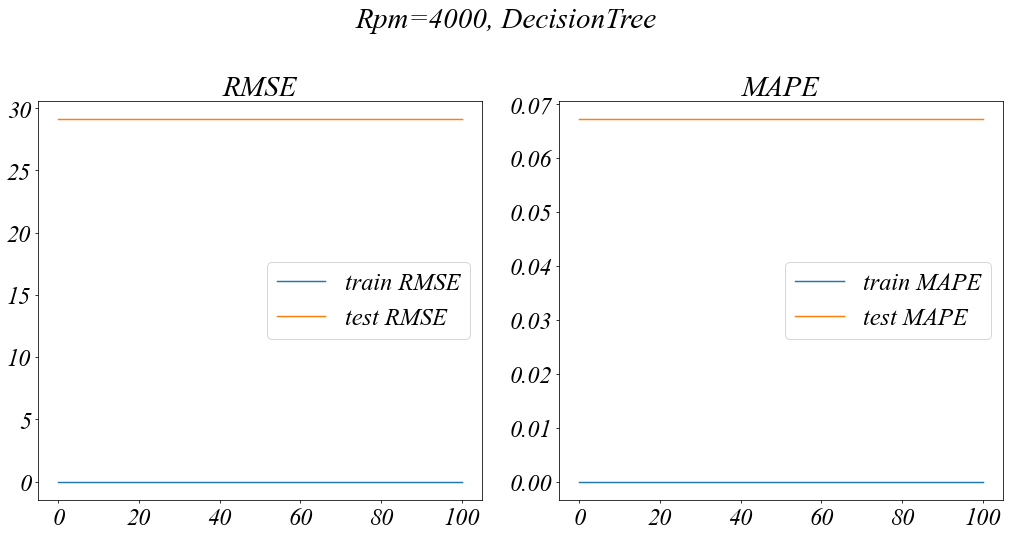

In [183]:
max_depth_curve(100,200,'Rpm=4000',X_train_scaled,X_test_scaled,y_train,y_test)

In [184]:
dt = DecisionTreeRegressor(max_depth=29,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=29, random_state=42)

In [185]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.71
50                    Ap        0.13
29     RMS_Y_CURRENT_std        0.04
35    RMS_Z_CURRENT_mean        0.04
14    RMS_SPINDLE_C_mean        0.03
49                    Ae        0.02
52                  feed        0.01
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
41    RMS_Z_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
51                   rpm        0.00
2

In [186]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 0.1075
Train MAPE: 0.0001
Test RMSE: 25.8771
Test MAPE: 0.0616


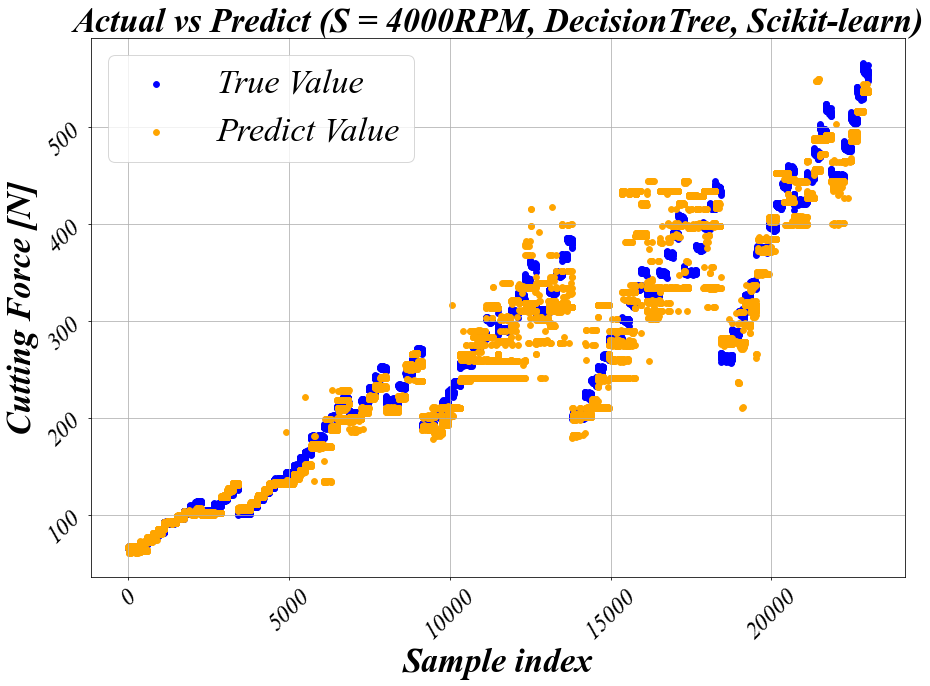

In [187]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 4000RPM, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning rpm4000 cycle.png")

## rpm 4500

In [188]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4000, rpm_5000], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [189]:
X_test = rpm_4500.iloc[: , 1:]
y_test = rpm_4500['RMS_CF_max']

In [190]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


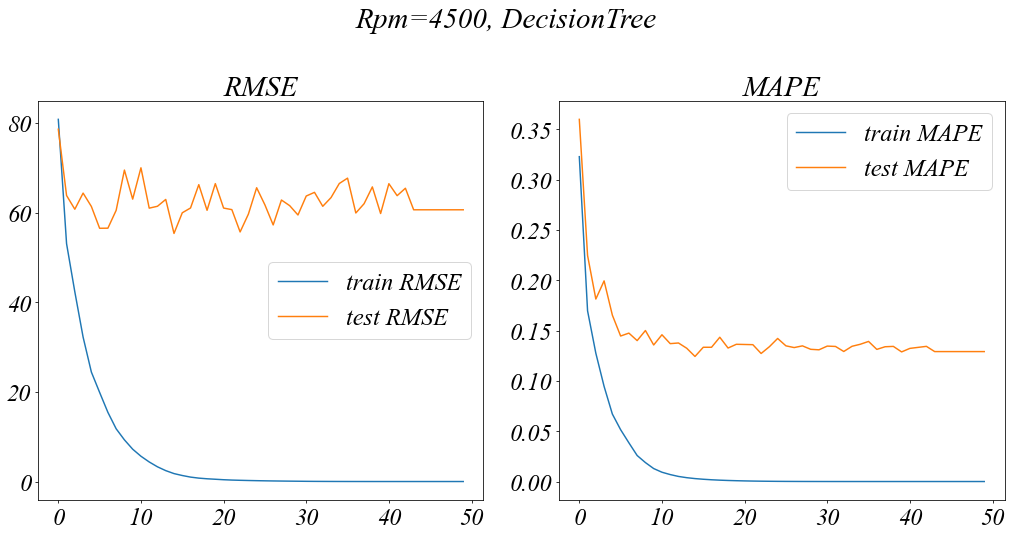

In [191]:
max_depth_curve(1,50,'Rpm=4500',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


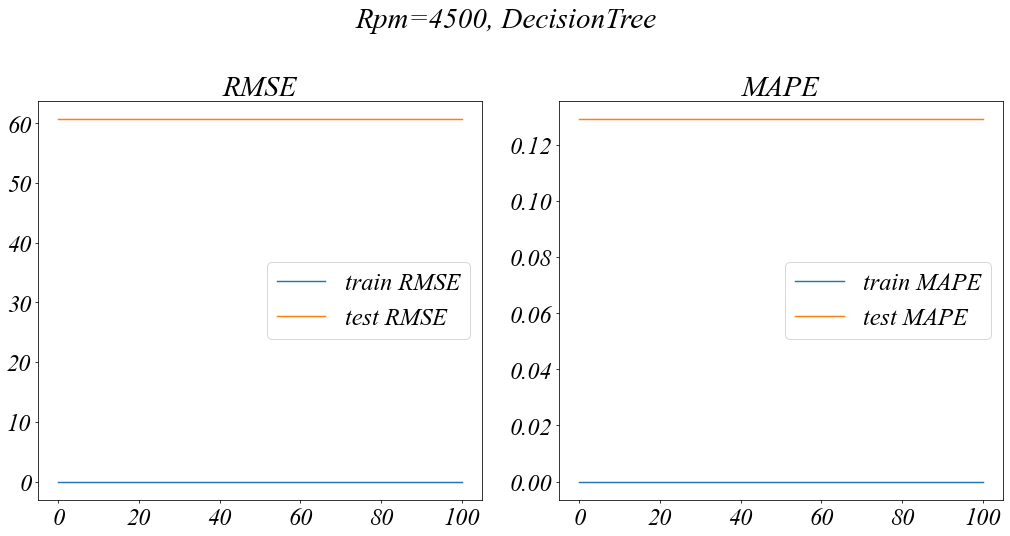

In [192]:
max_depth_curve(100,200,'Rpm=4500',X_train_scaled,X_test_scaled,y_train,y_test)

In [193]:
dt = DecisionTreeRegressor(max_depth=15,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=15, random_state=42)

In [194]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
43             SOUND_std        0.74
50                    Ap        0.11
29     RMS_Y_CURRENT_std        0.05
14    RMS_SPINDLE_C_mean        0.03
7     RMS_SPINDLE_V_mean        0.02
52                  feed        0.01
49                    Ae        0.01
47            SOUND_skew        0.00
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
36     RMS_Z_CURRENT_std        0.00
37  RMS_Z_CURRENT_median        0.00
39     RMS_Z_CURRENT_max        0.00
48            SOUND_kurt        0.00
40    RMS_Z_CURRENT_skew        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
4

In [195]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 1.7713
Train MAPE: 0.0029
Test RMSE: 55.3629
Test MAPE: 0.1242


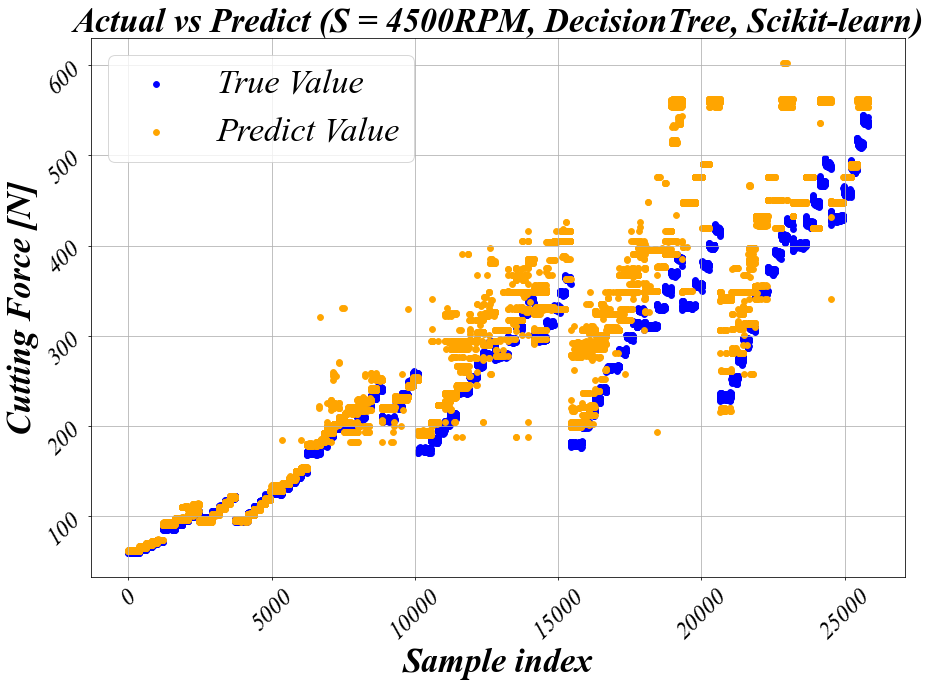

In [196]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 4500RPM, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning rpm4500 cycle.png")

## rpm 5000

In [197]:
train = pd.concat([rpm_3000, rpm_3500, rpm_4000, rpm_4500], axis  = 0)
train = train.reset_index(drop=True)
X_train = train.iloc[: , 1:]
y_train = train['RMS_CF_max']

In [198]:
X_test = rpm_5000.iloc[: , 1:]
y_test = rpm_5000['RMS_CF_max']

In [199]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Train finish


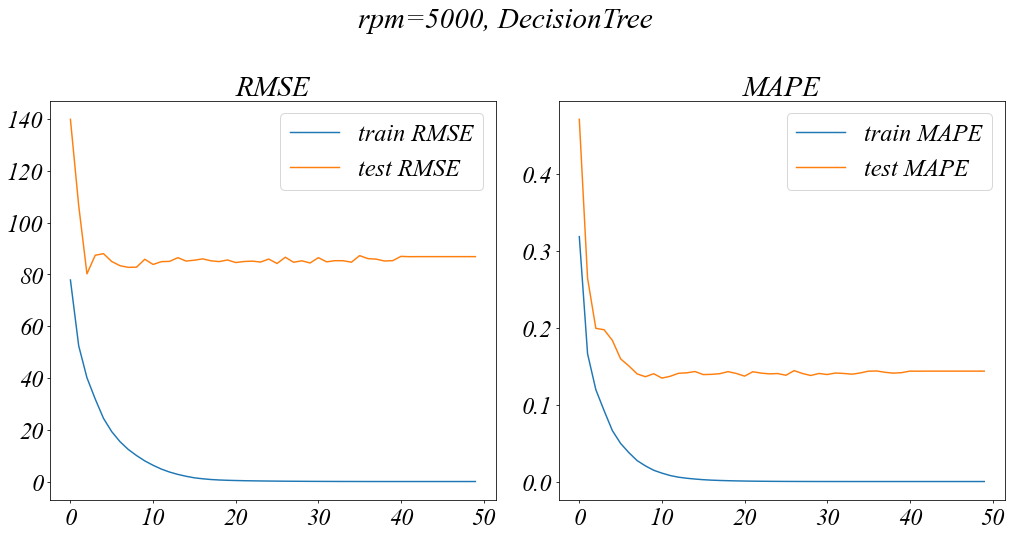

In [200]:
max_depth_curve(1,50,'rpm=5000',X_train_scaled,X_test_scaled,y_train,y_test)

Train finish


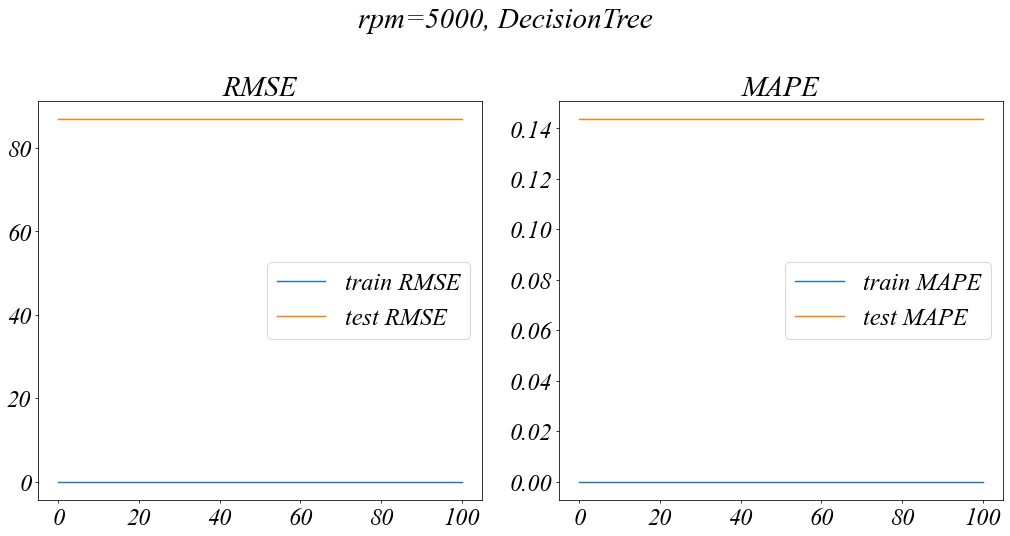

In [201]:
max_depth_curve(100,200,'rpm=5000',X_train_scaled,X_test_scaled,y_train,y_test)

In [206]:
dt = DecisionTreeRegressor(max_depth=3,random_state=42)
dt.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [208]:
# 변수의 중요도를 출력합니다.
# 0이면 클래스를 구분하는데 해당 피쳐가 선택되지 않았다는것,
# 1이면 해당 피쳐가 클래스를 완벽하게 나누었다는것을 의미
temp = {'feature name':X_train.columns, 'importance':np.round(dt.feature_importances_, 2)}
importance = pd.DataFrame(temp)
importance = importance.sort_values('importance',ascending=False)
print(importance)

            feature name  importance
29     RMS_Y_CURRENT_std        0.68
43             SOUND_std        0.16
50                    Ap        0.11
41    RMS_Z_CURRENT_kurt        0.04
36     RMS_Z_CURRENT_std        0.02
0           RMS_ACC_mean        0.00
38     RMS_Z_CURRENT_min        0.00
30  RMS_Y_CURRENT_median        0.00
31     RMS_Y_CURRENT_min        0.00
32     RMS_Y_CURRENT_max        0.00
33    RMS_Y_CURRENT_skew        0.00
34    RMS_Y_CURRENT_kurt        0.00
35    RMS_Z_CURRENT_mean        0.00
37  RMS_Z_CURRENT_median        0.00
40    RMS_Z_CURRENT_skew        0.00
39     RMS_Z_CURRENT_max        0.00
27    RMS_X_CURRENT_kurt        0.00
42            SOUND_mean        0.00
44          SOUND_median        0.00
45             SOUND_min        0.00
46             SOUND_max        0.00
47            SOUND_skew        0.00
48            SOUND_kurt        0.00
49                    Ae        0.00
51                   rpm        0.00
28    RMS_Y_CURRENT_mean        0.00
2

In [207]:
DT_train_pred = dt.predict(X_train_scaled)
DT_test_pred = dt.predict(X_test_scaled)

print('Train RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_train, DT_train_pred))))
print('Train MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_train, DT_train_pred)))

print('Test RMSE: {0:.4f}'.format(np.sqrt(mean_squared_error(y_test, DT_test_pred))))
print('Test MAPE: {0:.4f}'.format(mean_absolute_percentage_error(y_test, DT_test_pred)))

Train RMSE: 40.0770
Train MAPE: 0.1194
Test RMSE: 80.1988
Test MAPE: 0.1992


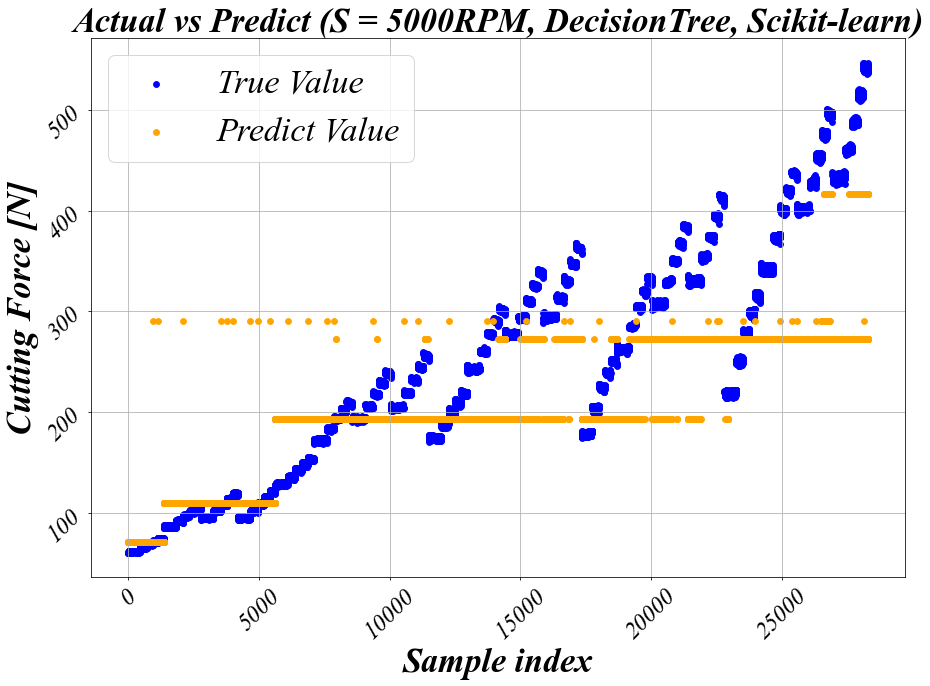

In [209]:
tfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

lfont={'fontname':'Times New Roman',
     'fontsize':35,
     'style':'italic',
     'fontweight':'bold'}

fig = plt.figure(figsize=(15,10),dpi=70)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 25
plt.rcParams['font.style'] = 'italic'
plt.title('Actual vs Predict (S = 5000RPM, DecisionTree, Scikit-learn)',**tfont)
plt.scatter(range(0, len(y_test)), y_test, label='True Value', color = 'blue')
#plt.ylim((0,300))
plt.scatter(range(0, len(DT_test_pred)), DT_test_pred, label='Predict Value', color = 'orange')
plt.xlabel(r'Sample index',**lfont)
plt.ylabel(r'Cutting Force [N]',**lfont)
plt.tick_params(labelrotation=45, labelsize=25)
plt.grid()
plt.legend(fontsize = 35)
plt.show()
#fig.savefig("./plot/Predict tuning rpm5000 cycle.png")